Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_50          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_51          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - loss: 0.1704 - val_loss: 0.0014
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - loss: 0.0079 - val_loss: 8.8873e-04
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.0048 - val_loss: 5.8684e-04
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0036 - val_loss: 7.8240e-04
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0030 - val_loss: 4.2104e-04
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0022 - val_loss: 4.0191e-04
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0019 - val_loss: 6.8210e-04
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0020 - val_loss: 4.6765e-04
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - loss: 0.0015 - val_loss: 4.9418e-04
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.0015 - val_loss: 3.1225e-04
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - loss: 0.0015 -

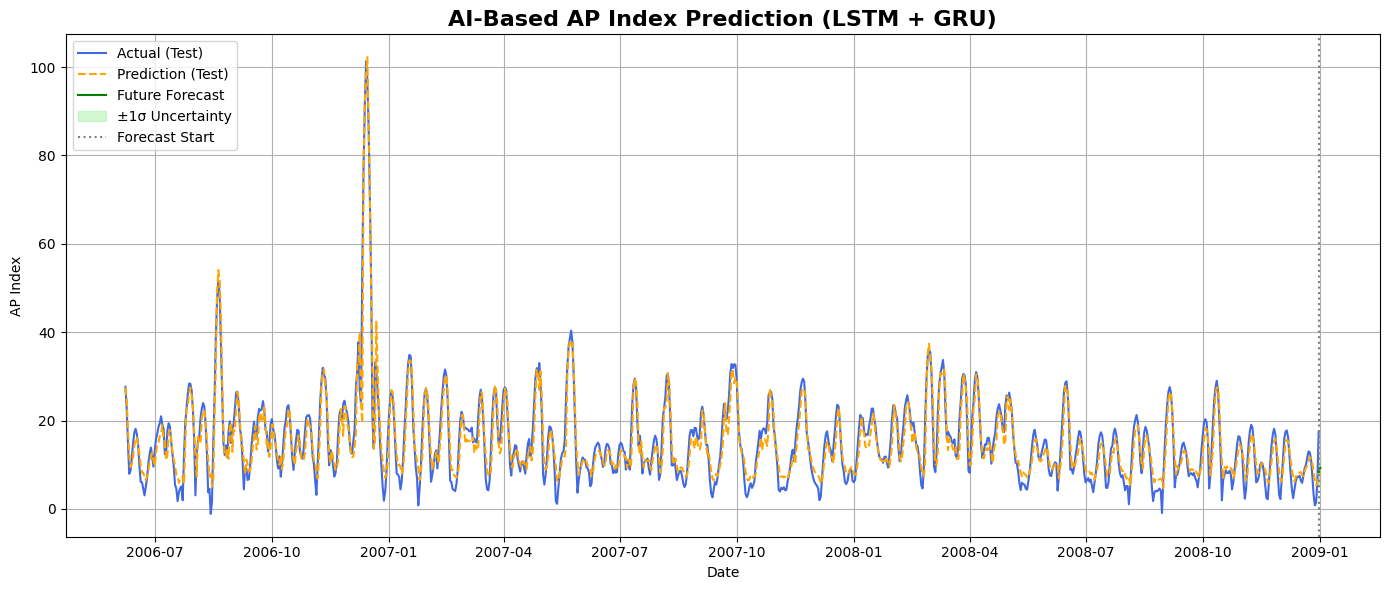

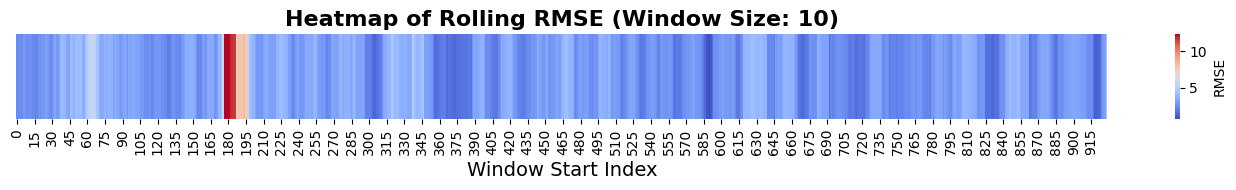

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("ap_index4.csv")
df.columns = df.columns.str.strip()
df['daily_ap_index'] = savgol_filter(df['daily_ap_index'], window_length=11, polyorder=3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'daily_ap_index']].dropna()
df.set_index('date', inplace=True)

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['daily_ap_index']])

# --- Create Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# Split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 10
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
nrmse = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
mbe = np.mean(residuals)
test_stat = np.mean(np.abs(residuals) / std_dev)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Display Evaluation Metrics ---
print("\n--- Evaluation Metrics ---")
print(f"RMSE           : {rmse:.3f}")
print(f"MAE            : {mae:.3f}")
print(f"MBE            : {mbe:.3f}")
print(f"NRMSE          : {nrmse:.3f}")
print(f"Standard Dev   : {std_dev:.3f}")
print(f"Test Statistic : {test_stat:.3f}")
print(f"R^2 Score      : {r2:.3f}")
print(f"Pearson r      : {pearson_r:.3f}")

# --- Sample Actual vs Predicted Values ---
print("\n--- Sample Actual vs Predicted Values ---")
for actual, pred in zip(y_test_inv[:10], y_pred_test_inv[:10]):
    print(f"Actual: {actual[0]:.3f} | Predicted: {pred[0]:.3f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(df.index[-len(y_test):], y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')

future_index = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='3H')[1:]
plt.plot(future_index, future_preds_inv, label='Future Forecast', color='green')
plt.fill_between(future_index,
                 (future_preds_inv - std_dev).flatten(),
                 (future_preds_inv + std_dev).flatten(),
                 color='lightgreen', alpha=0.4, label='±1σ Uncertainty')

plt.axvline(df.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title("AI-Based AP Index Prediction (LSTM + GRU)", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("AP Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE ---
window_size = 10
rolling_rmse = []
for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i+window_size]
    y_pred_window = y_pred_test_inv[i:i+window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)

rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2))
sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'})
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Window Start Index', fontsize=14)
plt.tight_layout()
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 170s 86ms/step - loss: 0.0315 - val_loss: 0.0016
Epoch 2/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 193s 102ms/step - loss: 0.0027 - val_loss: 5.3552e-04
Epoch 3/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 176s 93ms/step - loss: 0.0017 - val_loss: 6.2271e-04
Epoch 4/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 163s 86ms/step - loss: 0.0015 - val_loss: 4.9435e-04
Epoch 5/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 173s 91ms/step - loss: 0.0013 - val_loss: 7.0692e-04
Epoch 6/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 185s 97ms/step - loss: 0.0012 - val_loss: 5.5408e-04
Epoch 7/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 172s 91ms/step - loss: 0.0011 - val_loss: 4.2776e-04
Epoch 8/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 167s 88ms/step - loss: 0.0011 - val_loss: 4.1503e-04
Epoch 9/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 145s 76ms/step - loss: 9.6616e-04 - val_loss: 3.1420e-04
Epoch 10/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 144s 76ms/step - loss: 8.9096e-04 - val_loss: 5.1543e-04
Epoch 11/30
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 1

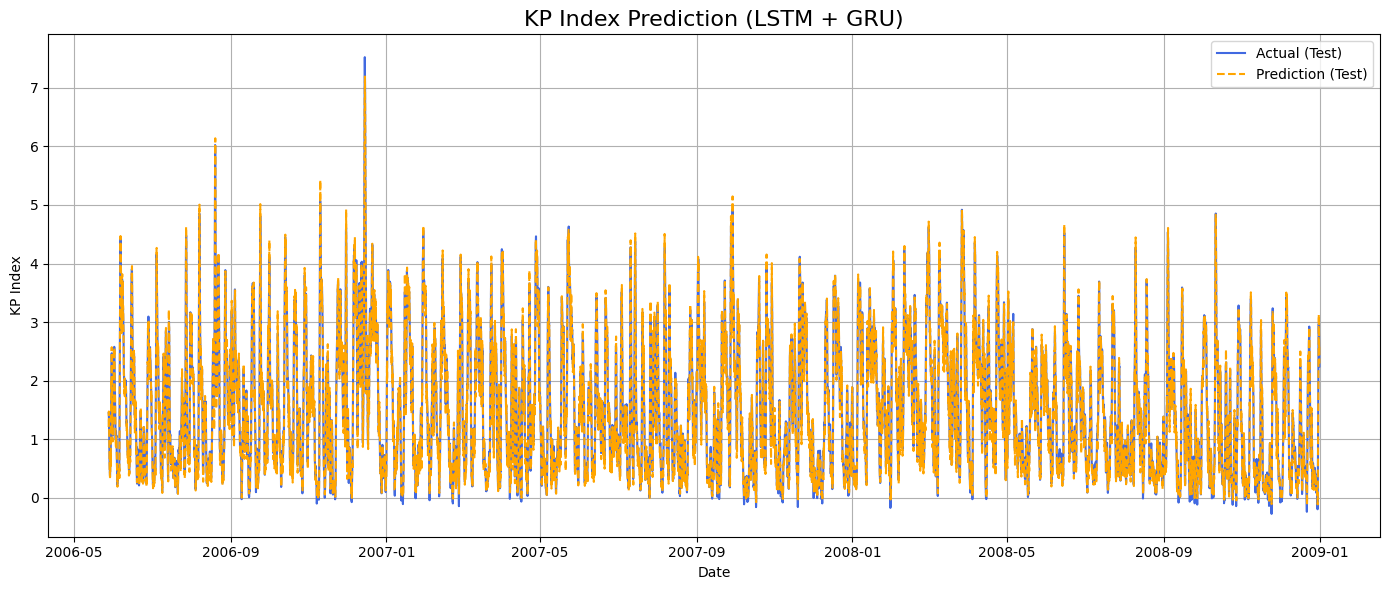

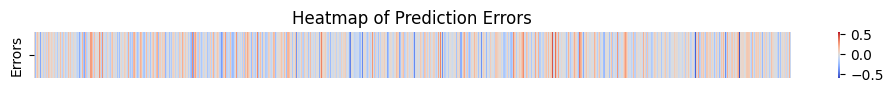

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter
from scipy.stats import ttest_1samp, pearsonr
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("kp index.csv")
df.columns = df.columns.str.strip()
df['value'] = savgol_filter(df['value'], 11, 3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'value']].dropna()
df.set_index('date', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['value']])

# --- Create Sequences ---
def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# --- Train/Test Split ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build LSTM + GRU Hybrid Model ---
input_layer = Input(shape=(sequence_length, 1))
x1 = LSTM(128, return_sequences=True)(input_layer)
x1 = LayerNormalization()(x1)
x1 = Dropout(0.4)(x1)

x2 = GRU(128, return_sequences=True)(x1)
x2 = LayerNormalization()(x2)
x2 = Dropout(0.4)(x2)

x3 = LSTM(128)(x2)
x3 = Dropout(0.4)(x3)

output = Dense(1)(x3)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    callbacks=[EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)],
    verbose=1
)

# --- Predict ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 120
y_future = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    y_future.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

y_future_inv = scaler.inverse_transform(np.array(y_future).reshape(-1, 1))

# --- Error and Evaluation Metrics ---
errors = y_pred_test_inv.flatten() - y_test_inv.flatten()
mbe = np.mean(errors)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
nrmse_mean = rmse / np.mean(y_test_inv)
nrmse_range = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
std_dev = np.std(errors)
t_stat, p_value = ttest_1samp(errors, 0.0)
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
corr_coef, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Print Metrics ---
print("\n--- Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Normalized RMSE (mean): {nrmse_mean:.4f}")
print(f"Normalized RMSE (range): {nrmse_range:.4f}")
print(f"Standard Deviation of Errors: {std_dev:.4f}")
print(f"t-Test Statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"MAE on Test: {mae:.2f}")
print(f"R² Score on Test: {r2:.4f}")
print(f"Pearson Correlation Coefficient: {corr_coef:.4f}")

# --- Sample Predictions ---
print("\nSample Actual vs Predicted KP Index Values:")
for i in range(10):
    actual = y_test_inv[i][0]
    predicted = y_pred_test_inv[i][0]
    print(f"Actual: {actual:.2f} | Predicted: {predicted:.2f}")

# --- Plot: Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(df.index[-len(y_test):], y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')
plt.title("KP Index Prediction (LSTM + GRU)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("KP Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap of Prediction Errors ---
error_df = pd.DataFrame({'Errors': errors})
heatmap_data = error_df.T
plt.figure(figsize=(10, 1))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, cbar=True, xticklabels=False)
plt.title("Heatmap of Prediction Errors")
plt.tight_layout()
plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - loss: 0.1891 - val_loss: 0.0030
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 266ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - loss: 0.0018 - val_loss: 6.7882e-04
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - loss: 0.0018 - val_loss: 0.0010
Epoc

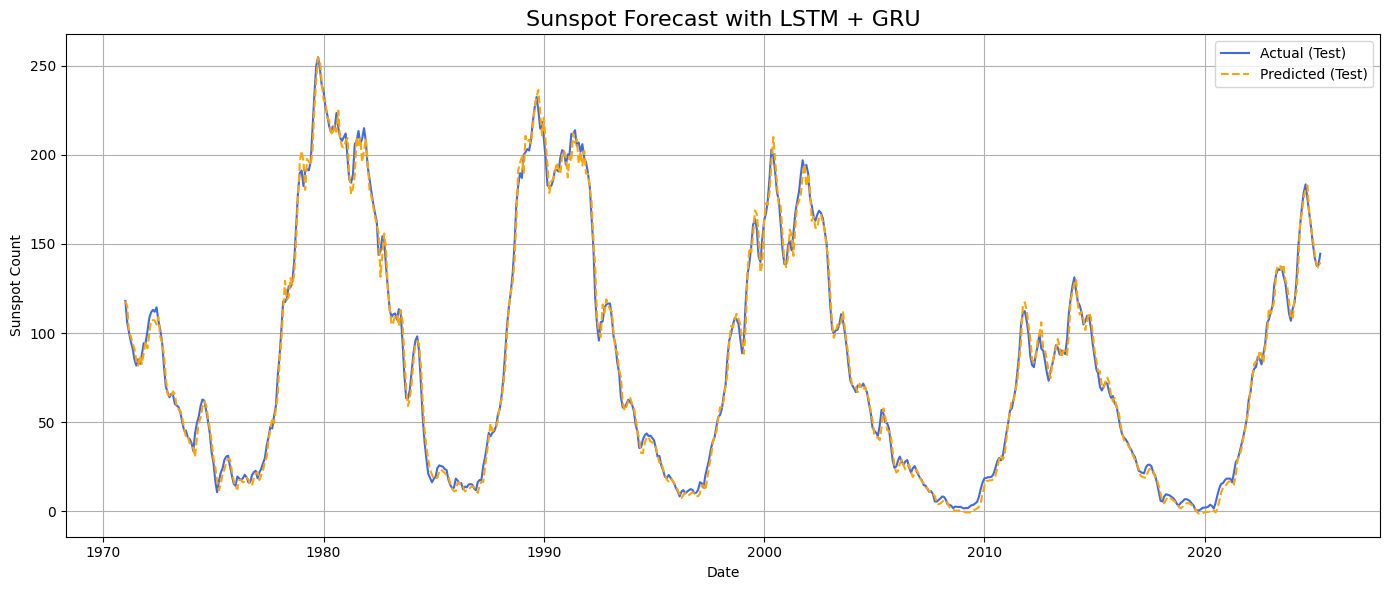

RMSE: 5.03
MAE: 3.85
R²: 0.9943
Residual Std Dev: 4.98
Pearson r: 0.997


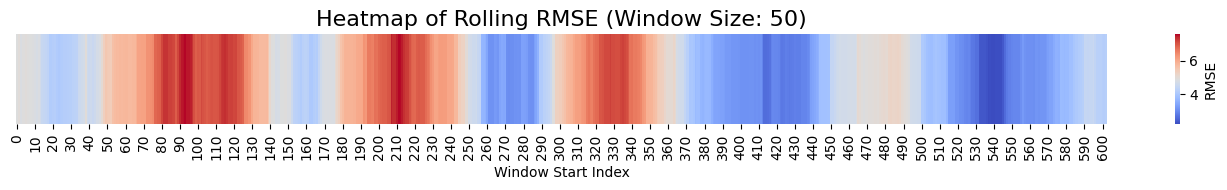


--- Additional Metrics ---
Mean Bias Error (MBE): -0.6789
Normalized RMSE (NRMSE): 0.0198
Test Statistic: 0.0057

--- Sample Actual vs Predicted Sunspot Values ---
 1. Actual: 118.01 | Predicted: 117.85
 2. Actual: 105.46 | Predicted: 115.01
 3. Actual: 100.51 | Predicted: 100.08
 4. Actual: 95.23 | Predicted: 98.27
 5. Actual: 91.43 | Predicted: 94.11
 6. Actual: 85.07 | Predicted: 91.16
 7. Actual: 81.72 | Predicted: 84.37
 8. Actual: 85.25 | Predicted: 81.70
 9. Actual: 82.74 | Predicted: 87.23
10. Actual: 87.88 | Predicted: 82.61


In [3]:
# --- Import Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions on Test Set ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)
'''
# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 20
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
'''
# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(df.index[-len(y_test):], y_pred_test_inv, label='Predicted (Test)', color='orange', linestyle='--')
plt.title("Sunspot Forecast with LSTM + GRU", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Evaluation Metrics ---
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Residual Std Dev: {std_dev:.2f}")
print(f"Pearson r: {pearson_r:.3f}")

# --- Rolling RMSE Plot ---
window_size = 50
rolling_rmse = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)

rolling_rmse = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2))
sns.heatmap(rolling_rmse, cmap='coolwarm', cbar_kws={'label': 'RMSE'})
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16)
plt.yticks([])
plt.xlabel('Window Start Index')
plt.tight_layout()
plt.show()

# --- Additional Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

mbe = mean_bias_error(y_test_inv, y_pred_test_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_test_inv)
test_statistic = np.mean((y_pred_test_inv - y_test_inv) ** 2) / np.var(y_test_inv)

print("\n--- Additional Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic: {test_statistic:.4f}")

# --- Print Sample Predictions ---
print("\n--- Sample Actual vs Predicted Sunspot Values ---")
for i in range(10):
    print(f"{i+1:>2}. Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 0.1597 - val_loss: 0.0026
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0087 - val_loss: 0.0018
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - loss: 0.0020 - val_loss: 8.3478e-04
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - loss: 0.0019 - val_loss: 5.6966e-04
Epoch

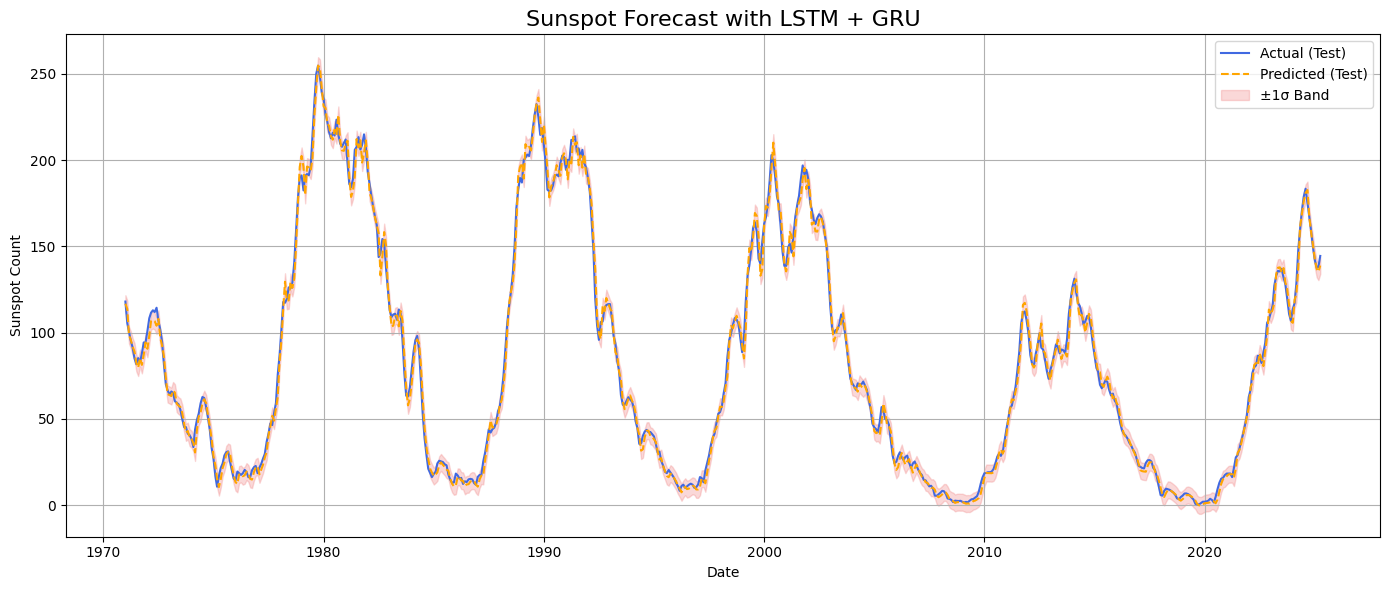


--- Core Evaluation Metrics ---
RMSE              : 4.95
MAE               : 3.67
R² Score          : 0.9945
Std. Dev. of Error: 4.90
Pearson r         : 0.997


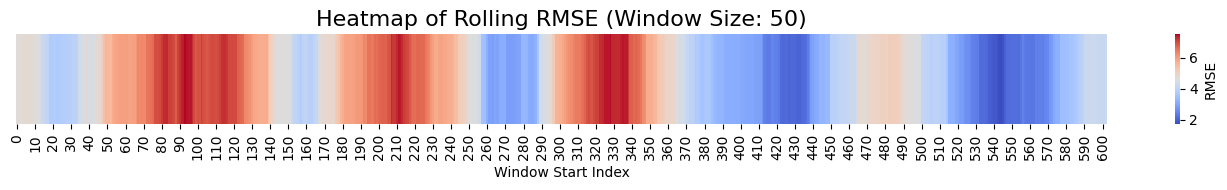


--- Additional Evaluation Metrics ---
Mean Bias Error (MBE): -0.6670
Normalized RMSE (NRMSE): 0.0195
Test Statistic         : 0.0055

--- Sample Actual vs Predicted Sunspot Values ---
 1. Actual: 118.01 | Predicted: 116.77
 2. Actual: 105.46 | Predicted: 113.76
 3. Actual: 100.51 | Predicted: 98.60
 4. Actual: 95.23 | Predicted: 95.81
 5. Actual: 91.43 | Predicted: 91.91
 6. Actual: 85.07 | Predicted: 89.01
 7. Actual: 81.72 | Predicted: 82.48
 8. Actual: 85.25 | Predicted: 79.76
 9. Actual: 82.74 | Predicted: 85.26
10. Actual: 87.88 | Predicted: 81.29


In [4]:
# --- Import Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions on Test Set ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 20
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Plot Actual vs Predicted with ±1σ ---
plt.figure(figsize=(14, 6))
test_dates = df.index[-len(y_test):]

plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Predicted (Test)', color='orange', linestyle='--')
plt.fill_between(test_dates,
                 (y_pred_test_inv - std_dev).flatten(),
                 (y_pred_test_inv + std_dev).flatten(),
                 color='lightcoral', alpha=0.3, label='±1σ Band')

plt.title("Sunspot Forecast with LSTM + GRU", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Evaluation Metrics ---
print("\n--- Core Evaluation Metrics ---")
print(f"RMSE              : {rmse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Std. Dev. of Error: {std_dev:.2f}")
print(f"Pearson r         : {pearson_r:.3f}")

# --- Rolling RMSE Plot ---
window_size = 50
rolling_rmse = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)

rolling_rmse = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2))
sns.heatmap(rolling_rmse, cmap='coolwarm', cbar_kws={'label': 'RMSE'})
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16)
plt.yticks([])
plt.xlabel('Window Start Index')
plt.tight_layout()
plt.show()

# --- Additional Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

mbe = mean_bias_error(y_test_inv, y_pred_test_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_test_inv)
test_statistic = np.mean((y_pred_test_inv - y_test_inv) ** 2) / np.var(y_test_inv)

print("\n--- Additional Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic         : {test_statistic:.4f}")

# --- Display Sample Predictions ---
print("\n--- Sample Actual vs Predicted Sunspot Values ---")
for i in range(10):
    print(f"{i+1:>2}. Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,617 (842.25 KB)

 Trainable params: 215,617 (842.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - loss: 0.1005 - val_loss: 0.0057
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 10/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 12/150
235/23

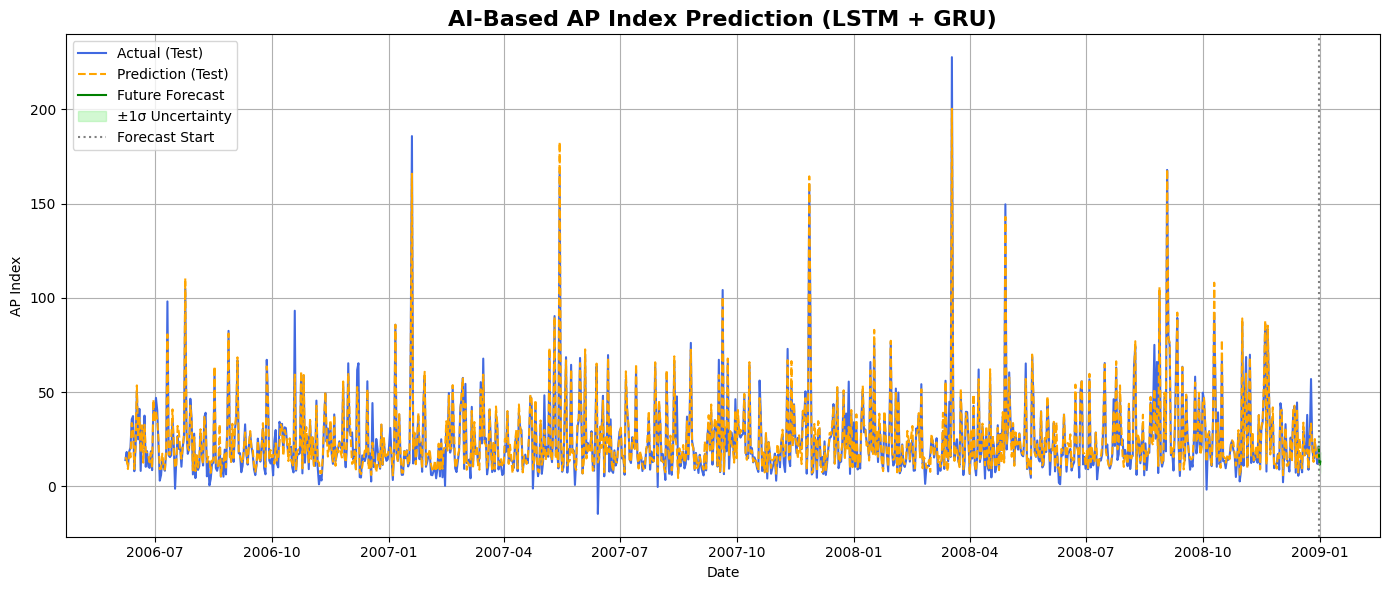

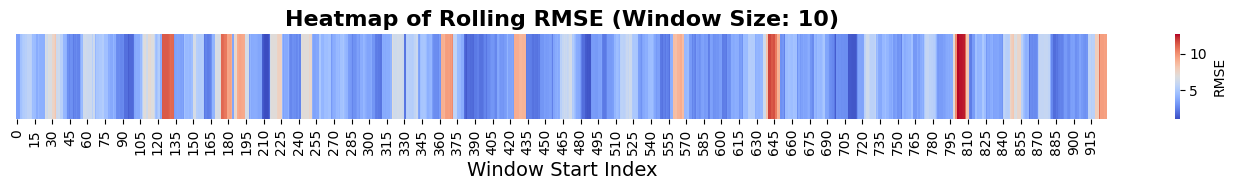

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("ap_index4.csv")
df.columns = df.columns.str.strip()
df['daily_ap_index'] = savgol_filter(df['daily_ap_index'], window_length=11, polyorder=3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'daily_ap_index']].dropna()
df.set_index('date', inplace=True)

# Normalize	scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['daily_ap_index']])

# --- Create Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# Shuffle to avoid temporal bias
indices = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = LSTM(64)(x)
x = Dropout(0.3)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=16,
    callbacks=[EarlyStopping(patience=25, restore_best_weights=True)],
    verbose=1
)

# --- Predictions ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 10
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
nrmse = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
mbe = np.mean(residuals)
test_stat = np.mean(np.abs(residuals) / std_dev)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Display Evaluation Metrics ---
print("\n--- Evaluation Metrics ---")
print(f"RMSE           : {rmse:.3f}")
print(f"MAE            : {mae:.3f}")
print(f"MBE            : {mbe:.3f}")
print(f"NRMSE          : {nrmse:.3f}")
print(f"Standard Dev   : {std_dev:.3f}")
print(f"Test Statistic : {test_stat:.3f}")
print(f"R^2 Score      : {r2:.3f}")
print(f"Pearson r      : {pearson_r:.3f}")

# --- Sample Actual vs Predicted Values ---
print("\n--- Sample Actual vs Predicted Values ---")
for actual, pred in zip(y_test_inv[:10], y_pred_test_inv[:10]):
    print(f"Actual: {actual[0]:.3f} | Predicted: {pred[0]:.3f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(df.index[-len(y_test):], y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')

future_index = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='3H')[1:]
plt.plot(future_index, future_preds_inv, label='Future Forecast', color='green')
plt.fill_between(future_index,
                 (future_preds_inv - std_dev).flatten(),
                 (future_preds_inv + std_dev).flatten(),
                 color='lightgreen', alpha=0.4, label='±1σ Uncertainty')

plt.axvline(df.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title("AI-Based AP Index Prediction (LSTM + GRU)", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("AP Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE ---
window_size = 10
rolling_rmse = []
for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i+window_size]
    y_pred_window = y_pred_test_inv[i:i+window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)

rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2))
sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'})
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Window Start Index', fontsize=14)
plt.tight_layout()
plt.show()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.2018 - val_loss: 0.0147
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0106 - val_loss: 0.0020
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0022 - val_loss: 9.9228e-04
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0019 - val_loss: 7.0879e-04
Epoch 12/10

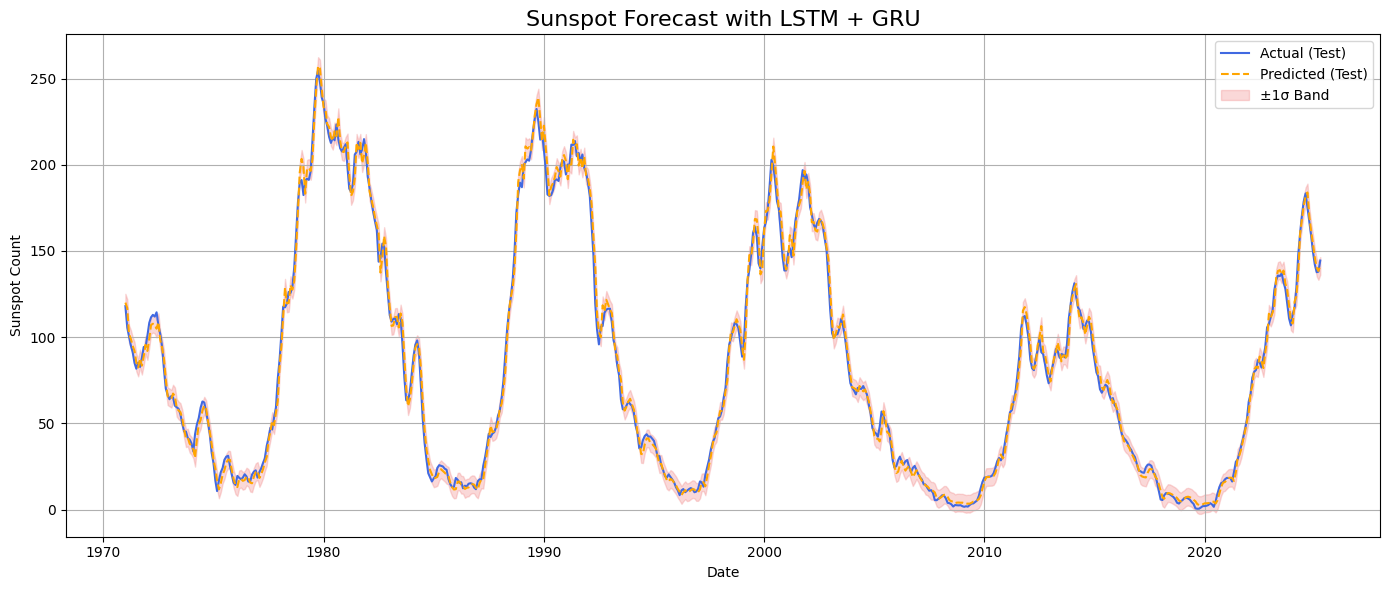

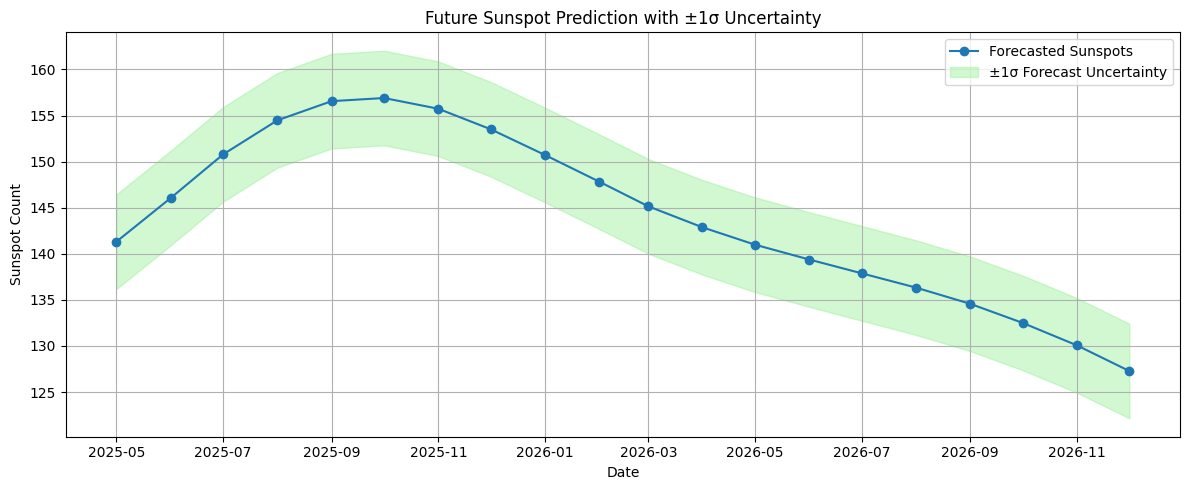


--- Future Sunspot Predictions ---
2025-05-01 : 141.31 ± 5.13 (Range: 136.18 to 146.45)
2025-06-01 : 146.05 ± 5.13 (Range: 140.92 to 151.18)
2025-07-01 : 150.79 ± 5.13 (Range: 145.66 to 155.92)
2025-08-01 : 154.48 ± 5.13 (Range: 149.35 to 159.61)
2025-09-01 : 156.56 ± 5.13 (Range: 151.43 to 161.69)
2025-10-01 : 156.90 ± 5.13 (Range: 151.77 to 162.03)
2025-11-01 : 155.74 ± 5.13 (Range: 150.61 to 160.87)
2025-12-01 : 153.51 ± 5.13 (Range: 148.38 to 158.64)
2026-01-01 : 150.72 ± 5.13 (Range: 145.59 to 155.85)
2026-02-01 : 147.82 ± 5.13 (Range: 142.69 to 152.96)
2026-03-01 : 145.15 ± 5.13 (Range: 140.02 to 150.29)
2026-04-01 : 142.87 ± 5.13 (Range: 137.74 to 148.00)
2026-05-01 : 140.99 ± 5.13 (Range: 135.86 to 146.12)
2026-06-01 : 139.38 ± 5.13 (Range: 134.25 to 144.51)
2026-07-01 : 137.88 ± 5.13 (Range: 132.75 to 143.01)
2026-08-01 : 136.34 ± 5.13 (Range: 131.20 to 141.47)
2026-09-01 : 134.58 ± 5.13 (Range: 129.45 to 139.71)
2026-10-01 : 132.50 ± 5.13 (Range: 127.37 to 137.64)
2026-11-01

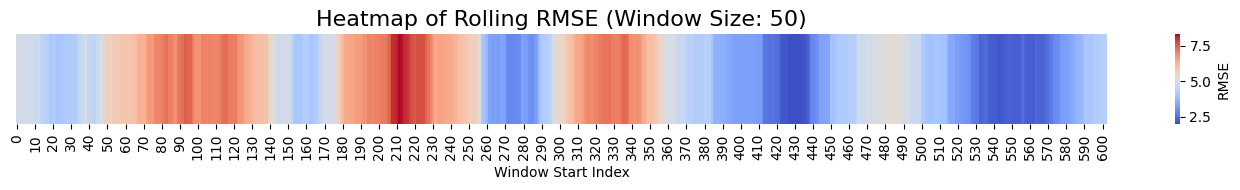


--- Additional Evaluation Metrics ---
Mean Bias Error (MBE): 0.2897
Normalized RMSE (NRMSE): 0.0202
Test Statistic         : 0.0060

--- Sample Actual vs Predicted Sunspot Values ---
 1. Actual: 118.01 | Predicted: 120.04
 2. Actual: 105.46 | Predicted: 116.89
 3. Actual: 100.51 | Predicted: 101.94
 4. Actual: 95.23 | Predicted: 99.04
 5. Actual: 91.43 | Predicted: 95.05
 6. Actual: 85.07 | Predicted: 92.02
 7. Actual: 81.72 | Predicted: 85.32
 8. Actual: 85.25 | Predicted: 82.40
 9. Actual: 82.74 | Predicted: 87.62
10. Actual: 87.88 | Predicted: 83.46


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions on Test Set ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 20
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Create Future Dates ---
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Plot Actual vs Predicted with ±1σ ---
plt.figure(figsize=(14, 6))
test_dates = df.index[-len(y_test):]

plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Predicted (Test)', color='orange', linestyle='--')
plt.fill_between(test_dates,
                 (y_pred_test_inv - std_dev).flatten(),
                 (y_pred_test_inv + std_dev).flatten(),
                 color='lightcoral', alpha=0.3, label='±1σ Band')

plt.title("Sunspot Forecast with LSTM + GRU", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Future Predictions with Uncertainty ---
plt.figure(figsize=(12, 5))
plt.plot(future_dates, future_preds_inv, label='Forecasted Sunspots', marker='o')
plt.fill_between(future_dates,
                 (future_preds_inv - std_dev).flatten(),
                 (future_preds_inv + std_dev).flatten(),
                 color='lightgreen', alpha=0.4, label='±1σ Forecast Uncertainty')
plt.title("Future Sunspot Prediction with ±1σ Uncertainty")
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Future Predictions ---
print("\n--- Future Sunspot Predictions ---")
for date, value in zip(future_dates, future_preds_inv):
    lower = value[0] - std_dev
    upper = value[0] + std_dev
    print(f"{date.date()} : {value[0]:.2f} ± {std_dev:.2f} (Range: {lower:.2f} to {upper:.2f})")

# --- Print Evaluation Metrics ---
print("\n--- Core Evaluation Metrics ---")
print(f"RMSE              : {rmse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Std. Dev. of Error: {std_dev:.2f}")
print(f"Pearson r         : {pearson_r:.3f}")

# --- Rolling RMSE Plot ---
window_size = 50
rolling_rmse = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)

rolling_rmse = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2))
sns.heatmap(rolling_rmse, cmap='coolwarm', cbar_kws={'label': 'RMSE'})
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16)
plt.yticks([])
plt.xlabel('Window Start Index')
plt.tight_layout()
plt.show()

# --- Additional Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

mbe = mean_bias_error(y_test_inv, y_pred_test_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_test_inv)
test_statistic = np.mean((y_pred_test_inv - y_test_inv) ** 2) / np.var(y_test_inv)

print("\n--- Additional Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic         : {test_statistic:.4f}")

# --- Display Sample Predictions ---
print("\n--- Sample Actual vs Predicted Sunspot Values ---")
for i in range(10):
    print(f"{i+1:>2}. Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.1710 - val_loss: 0.0035
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0087 - val_loss: 0.0016
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0021 - val_loss: 7.7830e-04
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0017 - val_loss: 8.3375e-04
Epoch 12/10

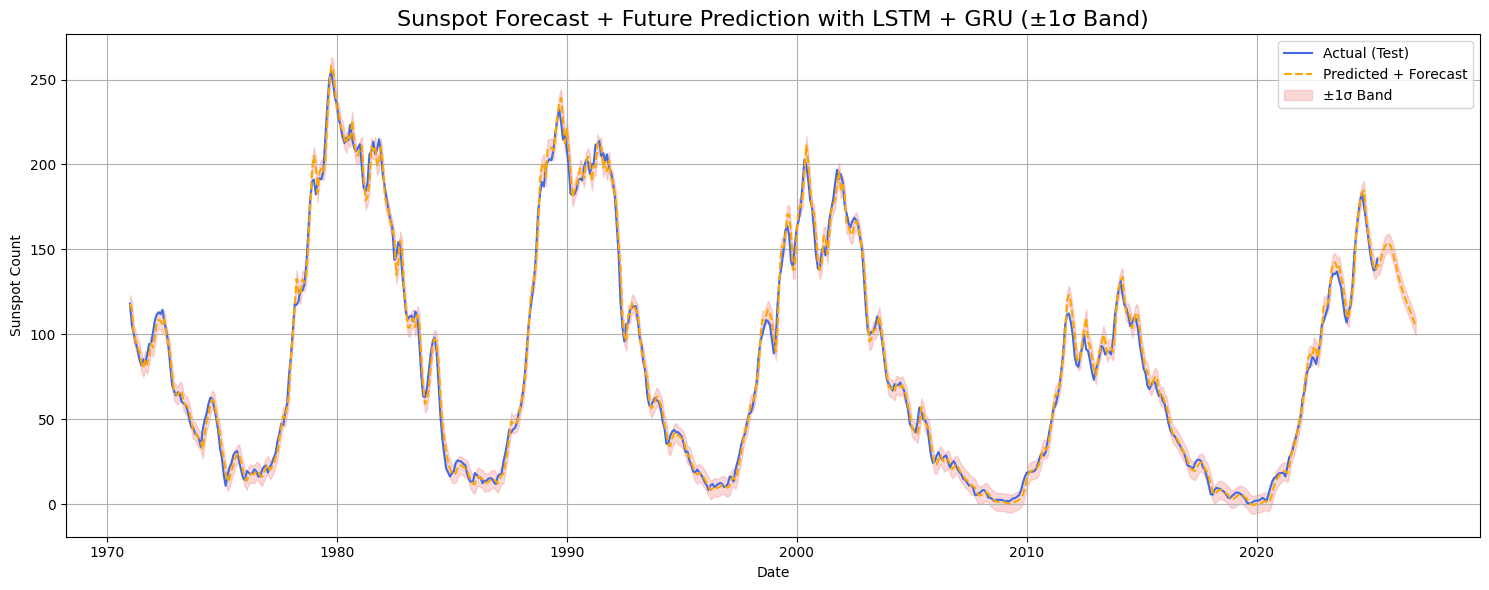


--- Future Sunspot Predictions ---
2025-05-01 : 140.53 ± 5.29 (Range: 135.23 to 145.82)
2025-06-01 : 144.49 ± 5.29 (Range: 139.19 to 149.78)
2025-07-01 : 148.65 ± 5.29 (Range: 143.35 to 153.94)
2025-08-01 : 152.00 ± 5.29 (Range: 146.70 to 157.29)
2025-09-01 : 153.81 ± 5.29 (Range: 148.52 to 159.11)
2025-10-01 : 153.75 ± 5.29 (Range: 148.45 to 159.04)
2025-11-01 : 151.84 ± 5.29 (Range: 146.54 to 157.13)
2025-12-01 : 148.41 ± 5.29 (Range: 143.12 to 153.71)
2026-01-01 : 143.99 ± 5.29 (Range: 138.70 to 149.29)
2026-02-01 : 139.16 ± 5.29 (Range: 133.86 to 144.45)
2026-03-01 : 134.40 ± 5.29 (Range: 129.11 to 139.70)
2026-04-01 : 130.06 ± 5.29 (Range: 124.76 to 135.35)
2026-05-01 : 126.24 ± 5.29 (Range: 120.94 to 131.53)
2026-06-01 : 122.87 ± 5.29 (Range: 117.57 to 128.16)
2026-07-01 : 119.82 ± 5.29 (Range: 114.53 to 125.12)
2026-08-01 : 116.97 ± 5.29 (Range: 111.67 to 122.26)
2026-09-01 : 114.10 ± 5.29 (Range: 108.81 to 119.40)
2026-10-01 : 111.10 ± 5.29 (Range: 105.80 to 116.39)
2026-11-01

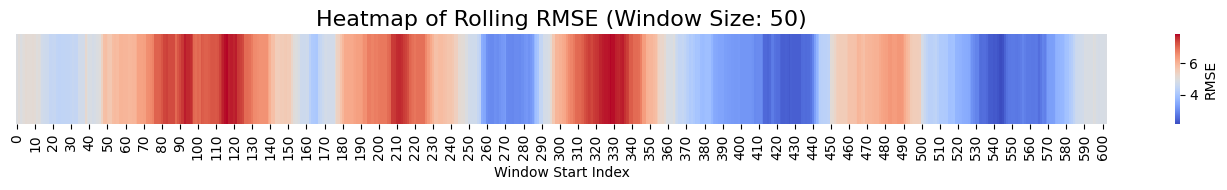


--- Additional Evaluation Metrics ---
Mean Bias Error (MBE): 0.5375
Normalized RMSE (NRMSE): 0.0209
Test Statistic         : 0.0064

--- Sample Actual vs Predicted Sunspot Values ---
 1. Actual: 118.01 | Predicted: 117.88
 2. Actual: 105.46 | Predicted: 114.55
 3. Actual: 100.51 | Predicted: 100.62
 4. Actual: 95.23 | Predicted: 96.57
 5. Actual: 91.43 | Predicted: 92.73
 6. Actual: 85.07 | Predicted: 89.65
 7. Actual: 81.72 | Predicted: 83.32
 8. Actual: 85.25 | Predicted: 80.19
 9. Actual: 82.74 | Predicted: 84.97
10. Actual: 87.88 | Predicted: 82.07


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions on Test Set ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 20
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Create Future Dates ---
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Combine Test and Forecast Dates ---
total_dates = np.concatenate([df.index[-len(y_test):], future_dates])
total_values = np.concatenate([y_pred_test_inv.flatten(), future_preds_inv.flatten()])
total_upper = total_values + std_dev
total_lower = total_values - std_dev

# --- Plot Actual vs Predicted + Future Forecasts with ±1σ ---
plt.figure(figsize=(15, 6))
plt.plot(df.index[-len(y_test):], y_test_inv.flatten(), label='Actual (Test)', color='royalblue')
plt.plot(total_dates, total_values, label='Predicted + Forecast', color='orange', linestyle='--')
plt.fill_between(total_dates, total_lower, total_upper, color='lightcoral', alpha=0.3, label='±1σ Band')
plt.title("Sunspot Forecast + Future Prediction with LSTM + GRU (±1σ Band)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Future Predictions ---
print("\n--- Future Sunspot Predictions ---")
for date, value in zip(future_dates, future_preds_inv):
    lower = value[0] - std_dev
    upper = value[0] + std_dev
    print(f"{date.date()} : {value[0]:.2f} ± {std_dev:.2f} (Range: {lower:.2f} to {upper:.2f})")

# --- Print Evaluation Metrics ---
print("\n--- Core Evaluation Metrics ---")
print(f"RMSE              : {rmse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Std. Dev. of Error: {std_dev:.2f}")
print(f"Pearson r         : {pearson_r:.3f}")

# --- Rolling RMSE Plot ---
window_size = 50
rolling_rmse = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)

rolling_rmse = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2))
sns.heatmap(rolling_rmse, cmap='coolwarm', cbar_kws={'label': 'RMSE'})
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16)
plt.yticks([])
plt.xlabel('Window Start Index')
plt.tight_layout()
plt.show()

# --- Additional Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

mbe = mean_bias_error(y_test_inv, y_pred_test_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_test_inv)
test_statistic = np.mean((y_pred_test_inv - y_test_inv) ** 2) / np.var(y_test_inv)

print("\n--- Additional Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic         : {test_statistic:.4f}")

# --- Display Sample Predictions ---
print("\n--- Sample Actual vs Predicted Sunspot Values ---")
for i in range(10):
    print(f"{i+1:>2}. Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - loss: 0.2598 - val_loss: 0.0025
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - loss: 0.0134 - val_loss: 0.0026
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 0.0025 - val_loss: 9.8141e-04
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 12/

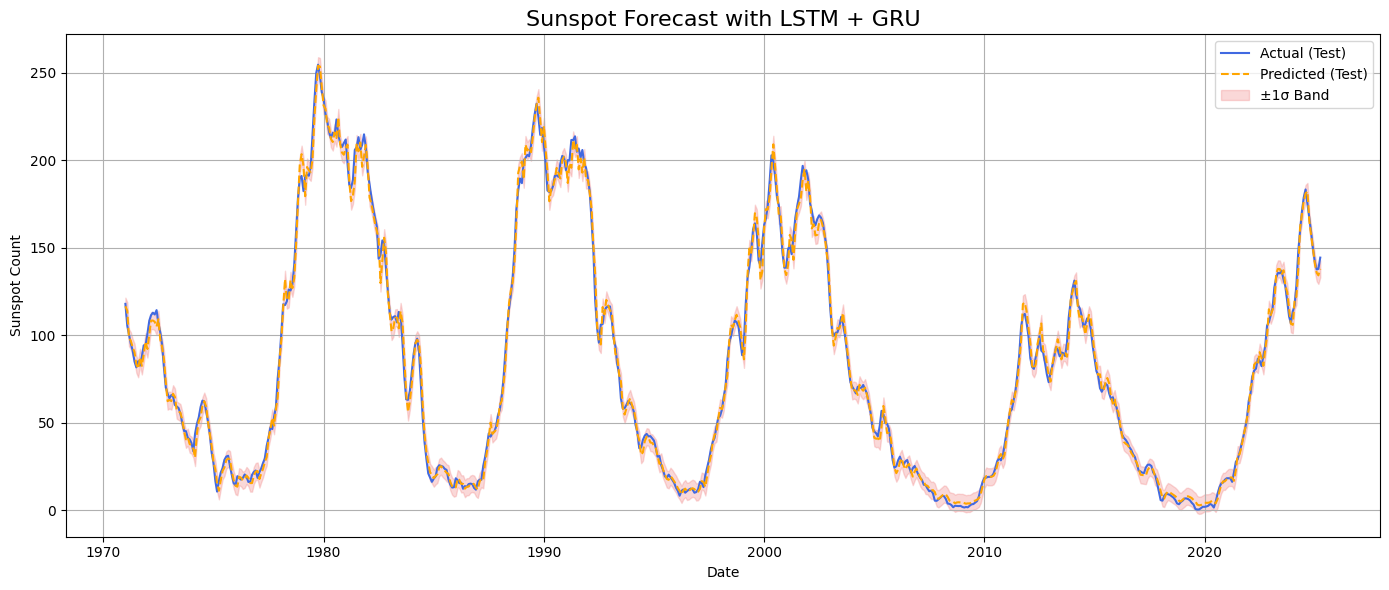

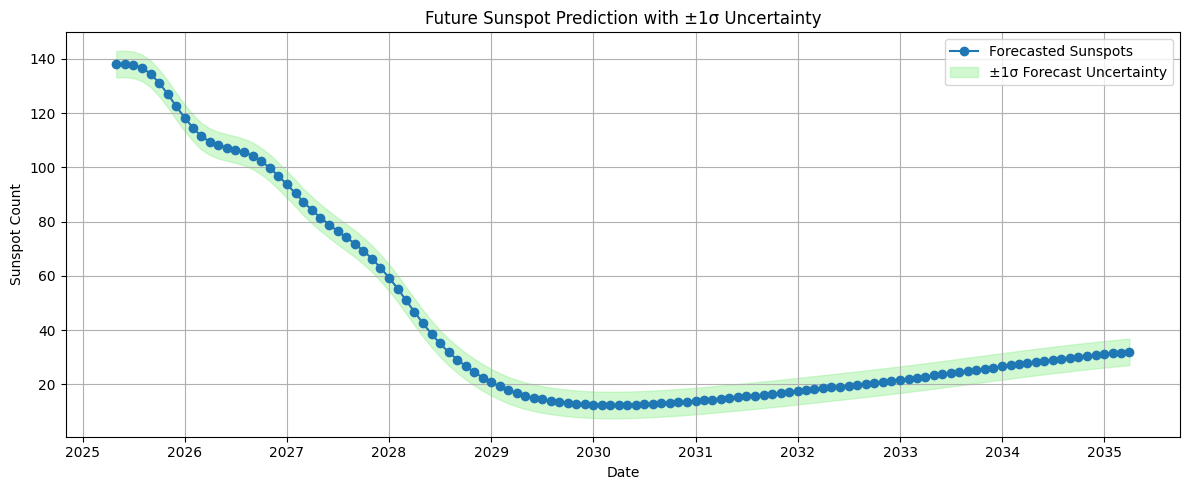

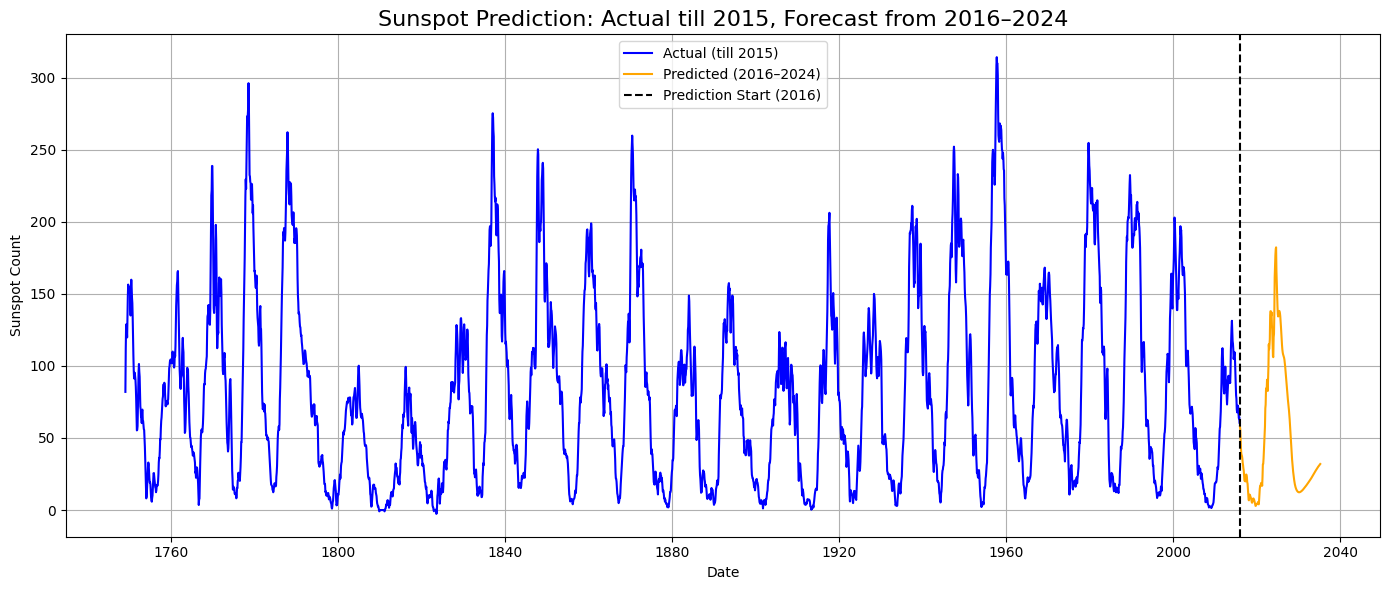


--- Future Sunspot Predictions ---
2025-05-01 : 138.02 ± 4.89 (Range: 133.13 to 142.91)
2025-06-01 : 138.12 ± 4.89 (Range: 133.23 to 143.01)
2025-07-01 : 137.83 ± 4.89 (Range: 132.94 to 142.72)
2025-08-01 : 136.69 ± 4.89 (Range: 131.80 to 141.58)
2025-09-01 : 134.46 ± 4.89 (Range: 129.57 to 139.35)
2025-10-01 : 131.15 ± 4.89 (Range: 126.26 to 136.04)
2025-11-01 : 127.03 ± 4.89 (Range: 122.14 to 131.92)
2025-12-01 : 122.53 ± 4.89 (Range: 117.64 to 127.42)
2026-01-01 : 118.17 ± 4.89 (Range: 113.28 to 123.06)
2026-02-01 : 114.39 ± 4.89 (Range: 109.50 to 119.28)
2026-03-01 : 111.46 ± 4.89 (Range: 106.57 to 116.35)
2026-04-01 : 109.42 ± 4.89 (Range: 104.53 to 114.31)
2026-05-01 : 108.13 ± 4.89 (Range: 103.24 to 113.03)
2026-06-01 : 107.29 ± 4.89 (Range: 102.40 to 112.18)
2026-07-01 : 106.55 ± 4.89 (Range: 101.66 to 111.45)
2026-08-01 : 105.61 ± 4.89 (Range: 100.72 to 110.51)
2026-09-01 : 104.23 ± 4.89 (Range: 99.34 to 109.12)
2026-10-01 : 102.28 ± 4.89 (Range: 97.39 to 107.17)
2026-11-01 :

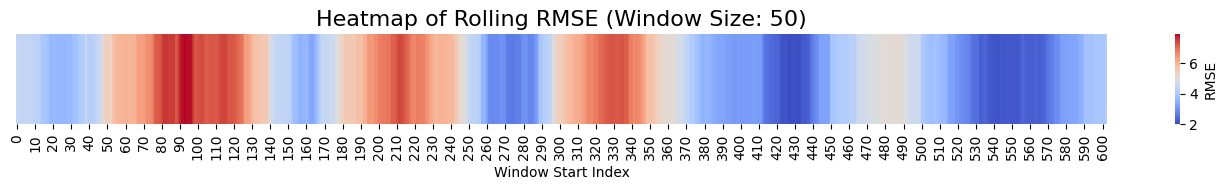


--- Additional Evaluation Metrics ---
Mean Bias Error (MBE): -0.3259
Normalized RMSE (NRMSE): 0.0193
Test Statistic         : 0.0054

--- Sample Actual vs Predicted Sunspot Values ---
 1. Actual: 118.01 | Predicted: 116.66
 2. Actual: 105.46 | Predicted: 114.09
 3. Actual: 100.51 | Predicted: 98.76
 4. Actual: 95.23 | Predicted: 96.89
 5. Actual: 91.43 | Predicted: 93.14
 6. Actual: 85.07 | Predicted: 90.42
 7. Actual: 81.72 | Predicted: 83.51
 8. Actual: 85.25 | Predicted: 80.94
 9. Actual: 82.74 | Predicted: 87.43
10. Actual: 87.88 | Predicted: 82.56


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions on Test Set ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 10 * 12  # Forecast for 20 years monthly
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Create Future Dates ---
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())



# --- Combined Plot: Actual till 2015, Predicted from 2016–2024 ---
actual_upto_2015 = df[df.index < '2016-01-01']['sunspot']
test_pred_dates = df.index[-len(y_test_inv):]
start_2016_index = np.where(test_pred_dates >= pd.to_datetime('2016-01-01'))[0][0]
predicted_2016_2024 = np.concatenate([y_pred_test_inv[start_2016_index:], future_preds_inv])
predicted_2016_2024_dates = pd.date_range(start=test_pred_dates[start_2016_index], periods=len(predicted_2016_2024), freq='MS')

plt.figure(figsize=(14, 6))
plt.plot(actual_upto_2015.index, actual_upto_2015.values, label='Actual (till 2015)', color='blue')
plt.plot(predicted_2016_2024_dates, predicted_2016_2024, label='Predicted (2016–2024)', color='orange')
plt.axvline(pd.to_datetime('2016-01-01'), color='black', linestyle='--', label='Prediction Start (2016)')
plt.title("Sunspot Prediction: Actual till 2015, Forecast from 2016–2024", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation Reports ---
print("\n--- Future Sunspot Predictions ---")
for date, value in zip(future_dates, future_preds_inv):
    lower = value[0] - std_dev
    upper = value[0] + std_dev
    print(f"{date.date()} : {value[0]:.2f} ± {std_dev:.2f} (Range: {lower:.2f} to {upper:.2f})")

print("\n--- Core Evaluation Metrics ---")
print(f"RMSE              : {rmse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Std. Dev. of Error: {std_dev:.2f}")
print(f"Pearson r         : {pearson_r:.3f}")



# --- Additional Evaluation Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

mbe = mean_bias_error(y_test_inv, y_pred_test_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_test_inv)
test_statistic = np.mean((y_pred_test_inv - y_test_inv) ** 2) / np.var(y_test_inv)

print("\n--- Additional Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic         : {test_statistic:.4f}")

print("\n--- Sample Actual vs Predicted Sunspot Values ---")
for i in range(10):
    print(f"{i+1:>2}. Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - loss: 0.1444 - val_loss: 0.0067
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.0085 - val_loss: 0.0014
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.0054 - val_loss: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.0040 - val_loss: 5.0380e-04
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.0028 - val_loss: 4.0568e-04
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.0024 - val_loss: 4.2762e-04
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.0020 - val_loss: 5.1132e-04
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.0019 - val_loss: 3.5864e-04
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0018 - val_loss: 4.4263e-04
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - loss: 0.0016 - val_loss: 6.8490e-04
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - loss: 0.0015 - val_loss

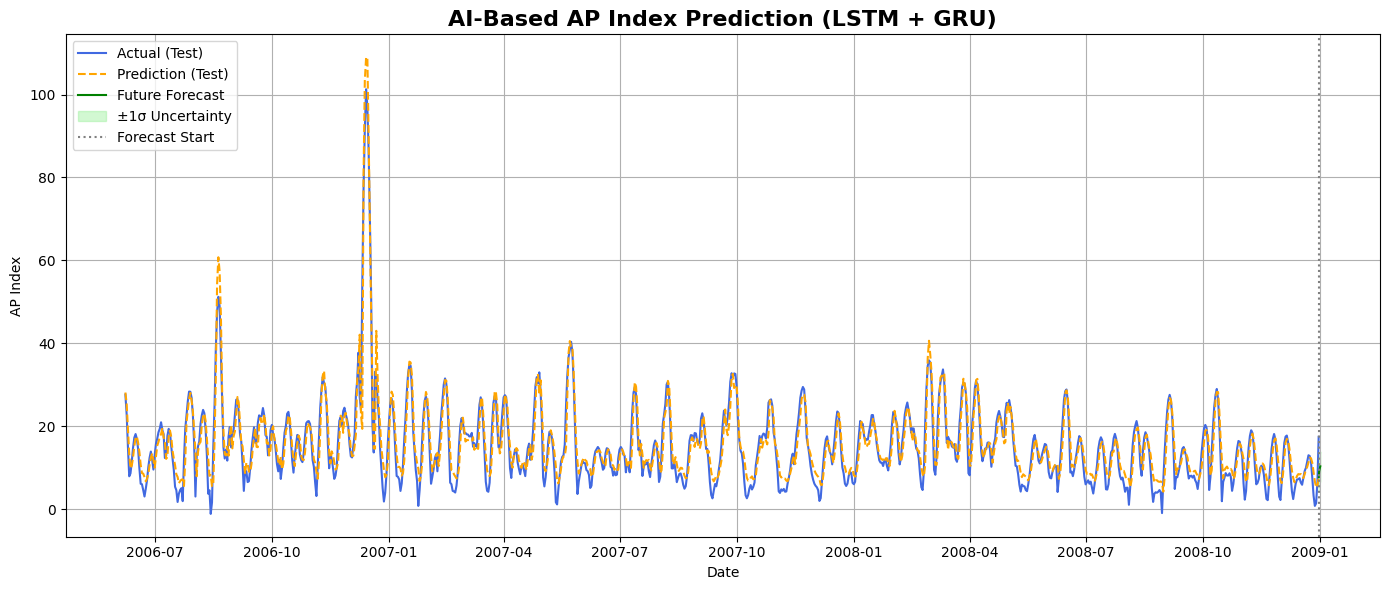

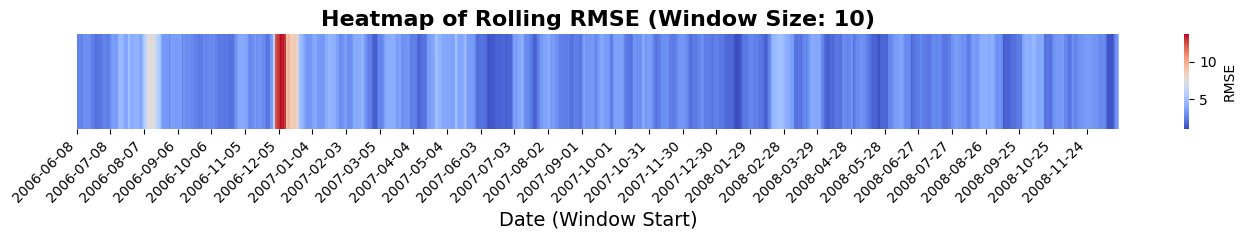

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("ap_index4.csv")
df.columns = df.columns.str.strip()
df['daily_ap_index'] = savgol_filter(df['daily_ap_index'], window_length=11, polyorder=3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'daily_ap_index']].dropna()
df.set_index('date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['daily_ap_index']])

# --- Create Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Train-Test Split ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
test_dates = df.index[-len(y_test):]  # Save test dates for plotting

# --- Build LSTM-GRU Hybrid Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 10
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
nrmse = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
mbe = np.mean(residuals)
test_stat = np.mean(np.abs(residuals) / std_dev)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Display Evaluation Metrics ---
print("\n--- Evaluation Metrics ---")
print(f"RMSE           : {rmse:.3f}")
print(f"MAE            : {mae:.3f}")
print(f"MBE            : {mbe:.3f}")
print(f"NRMSE          : {nrmse:.3f}")
print(f"Standard Dev   : {std_dev:.3f}")
print(f"Test Statistic : {test_stat:.3f}")
print(f"R^2 Score      : {r2:.3f}")
print(f"Pearson r      : {pearson_r:.3f}")

# --- Sample Actual vs Predicted Values ---
print("\n--- Sample Actual vs Predicted Values ---")
for actual, pred in zip(y_test_inv[:10], y_pred_test_inv[:10]):
    print(f"Actual: {actual[0]:.3f} | Predicted: {pred[0]:.3f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')

# Plot future forecast
future_index = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='3H')[1:]
plt.plot(future_index, future_preds_inv, label='Future Forecast', color='green')
plt.fill_between(future_index,
                 (future_preds_inv - std_dev).flatten(),
                 (future_preds_inv + std_dev).flatten(),
                 color='lightgreen', alpha=0.4, label='±1σ Uncertainty')

plt.axvline(df.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title("AI-Based AP Index Prediction (LSTM + GRU)", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("AP Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE with Cleaned X-axis ---
window_size = 10
rolling_rmse = []
rolling_dates = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)
    rolling_dates.append(test_dates[i])

# Convert for heatmap
rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)

# Fix x-axis: show fewer ticks to avoid clutter
stride = max(1, len(rolling_dates) // 30)  # show ~30 ticks max
xticks = ax.set_xticks(np.arange(0, len(rolling_dates), stride))
xticklabels = ax.set_xticklabels([rolling_dates[i].strftime('%Y-%m-%d') for i in range(0, len(rolling_dates), stride)],
                                 rotation=45, ha='right')

plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 159s 81ms/step - loss: 0.0350 - val_loss: 9.8692e-04
Epoch 2/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 191s 101ms/step - loss: 0.0027 - val_loss: 5.3001e-04
Epoch 3/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 180s 95ms/step - loss: 0.0017 - val_loss: 5.5908e-04
Epoch 4/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 202s 107ms/step - loss: 0.0015 - val_loss: 6.7298e-04
Epoch 5/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 201s 106ms/step - loss: 0.0013 - val_loss: 4.1500e-04
Epoch 6/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 206s 109ms/step - loss: 0.0013 - val_loss: 4.4979e-04
Epoch 7/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 189s 100ms/step - loss: 0.0011 - val_loss: 4.0034e-04
Epoch 8/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 185s 97ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 188s 99ms/step - loss: 0.0010 - val_loss: 3.8070e-04
Epoch 10/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 468s 247ms/step - loss: 9.6053e-04 - val_loss: 4.4311e-04
238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step


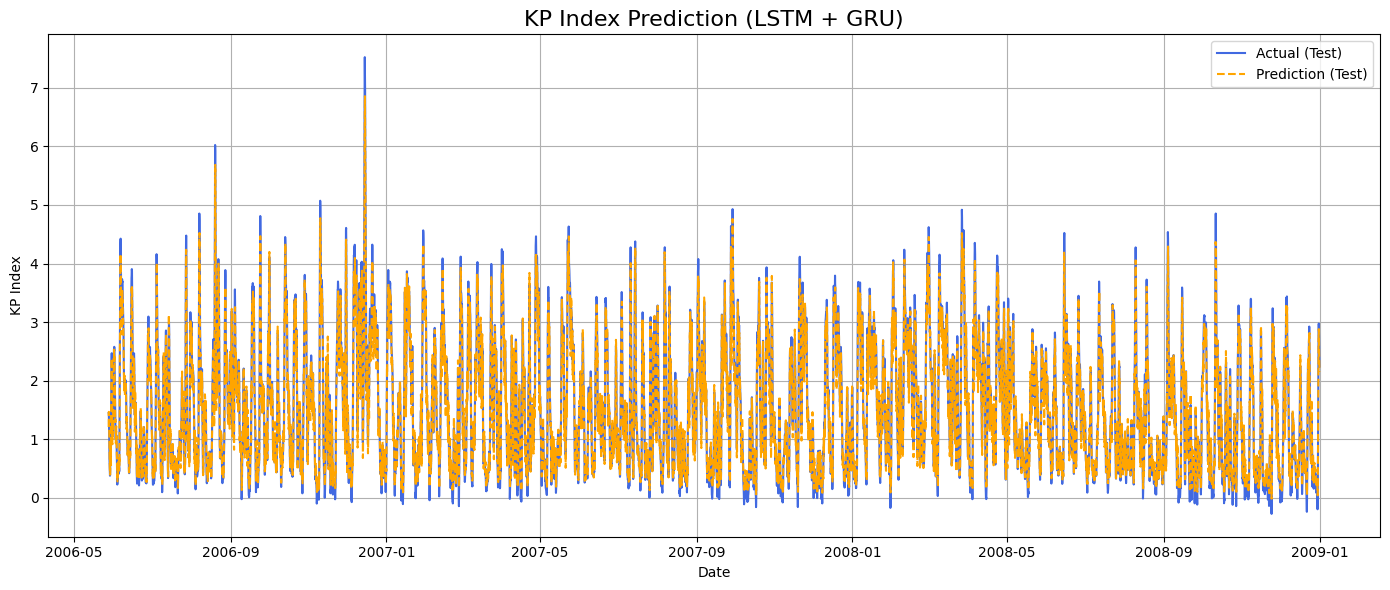

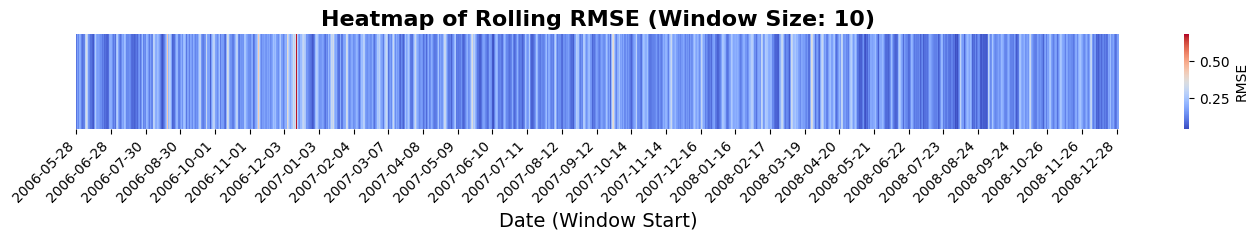

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter
from scipy.stats import ttest_1samp
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("kp index.csv")
df.columns = df.columns.str.strip()
df['value'] = savgol_filter(df['value'], 11, 3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'value']].dropna()
df.set_index('date', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['value']])

# --- Create Sequences ---
def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# --- Train/Test Split ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
test_dates = df.index[-len(y_test):]

# --- Build LSTM + GRU Hybrid Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = LSTM(128)(x)
x = Dropout(0.4)(x)
output = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predict ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 120
y_future = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    y_future.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

y_future_inv = scaler.inverse_transform(np.array(y_future).reshape(-1, 1))

# --- Calculate Prediction Errors ---
errors = y_pred_test_inv.flatten() - y_test_inv.flatten()
mbe = np.mean(errors)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
nrmse_mean = rmse / np.mean(y_test_inv)
nrmse_range = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
std_dev = np.std(errors)
t_stat, p_value = ttest_1samp(errors, 0.0)

# --- Print Evaluation Metrics ---
print("\n--- Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Normalized RMSE (mean): {nrmse_mean:.4f}")
print(f"Normalized RMSE (range): {nrmse_range:.4f}")
print(f"Standard Deviation of Errors: {std_dev:.4f}")
print(f"t-Test Statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# --- Additional Metrics ---
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
print(f"\nMAE on Test: {mae:.2f}")
print(f"R² Score on Test: {r2:.4f}")

# --- Sample Predictions ---
print("\nSample Actual vs Predicted KP Index Values:")
for i in range(10):
    print(f"Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')
plt.title("KP Index Prediction (LSTM + GRU)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("KP Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE (Aligned with Dates) ---
window_size = 10
rolling_rmse = []
rolling_dates = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)
    rolling_dates.append(test_dates[i])

rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)
stride = max(1, len(rolling_dates) // 30)
ax.set_xticks(np.arange(0, len(rolling_dates), stride))
ax.set_xticklabels([rolling_dates[i].strftime('%Y-%m-%d') for i in range(0, len(rolling_dates), stride)],
                   rotation=45, ha='right')
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 155s 79ms/step - loss: 0.0366 - val_loss: 9.2153e-04
Epoch 2/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 170s 90ms/step - loss: 0.0027 - val_loss: 6.1689e-04
Epoch 3/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 177s 93ms/step - loss: 0.0017 - val_loss: 5.9840e-04
Epoch 4/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 191s 101ms/step - loss: 0.0015 - val_loss: 8.4432e-04
Epoch 5/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 193s 102ms/step - loss: 0.0014 - val_loss: 3.4995e-04
Epoch 6/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 177s 93ms/step - loss: 0.0013 - val_loss: 7.1057e-04
Epoch 7/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 184s 97ms/step - loss: 0.0012 - val_loss: 4.6895e-04
Epoch 8/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 220s 116ms/step - loss: 0.0011 - val_loss: 4.3162e-04
Epoch 9/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 202s 106ms/step - loss: 0.0010 - val_loss: 3.0676e-04
Epoch 10/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 178s 94ms/step - loss: 9.3861e-04 - val_loss: 3.2787e-04
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/ste

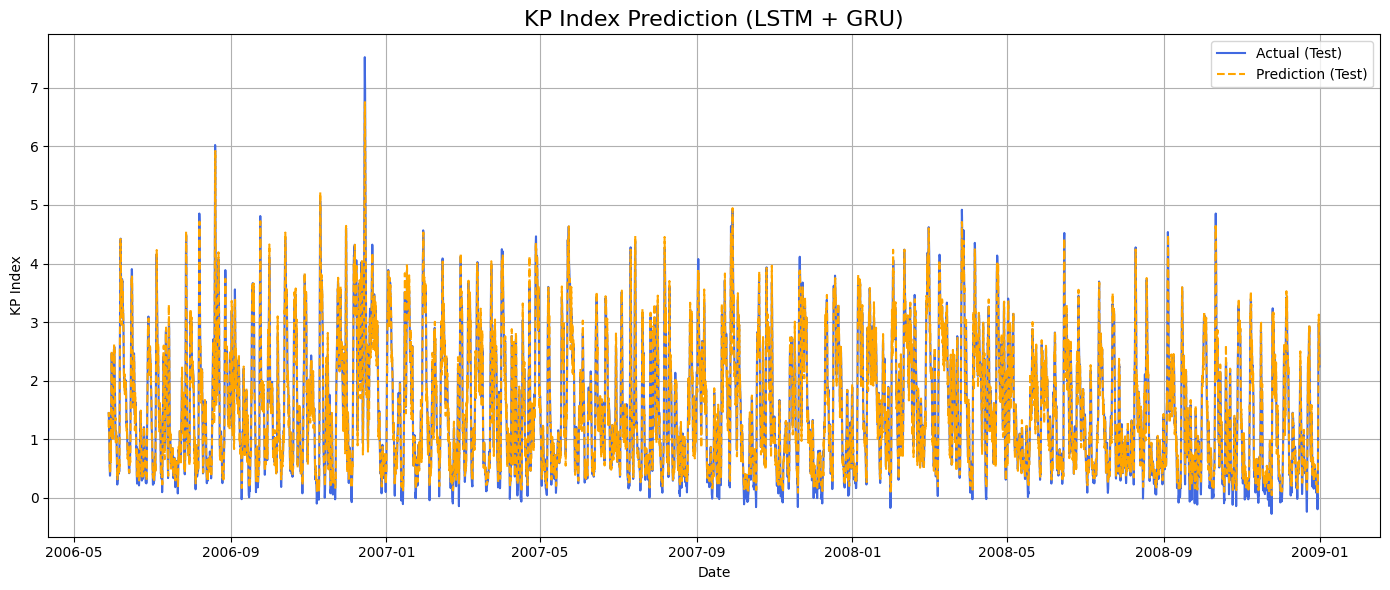

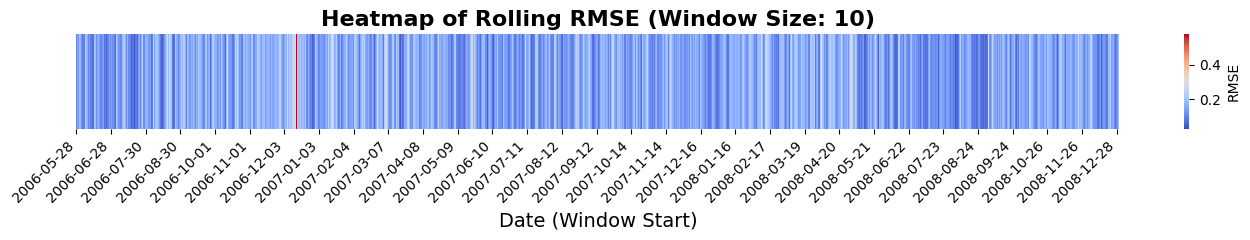

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter
from scipy.stats import ttest_1samp
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("kp index.csv")
df.columns = df.columns.str.strip()
df['value'] = savgol_filter(df['value'], 11, 3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'value']].dropna()
df.set_index('date', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['value']])

# --- Create Sequences ---
def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# --- Train/Test Split ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
test_dates = df.index[-len(y_test):]

# --- Build LSTM + GRU Hybrid Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = LSTM(128)(x)
x = Dropout(0.4)(x)
output = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predict ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Calculate Prediction Errors ---
errors = y_pred_test_inv.flatten() - y_test_inv.flatten()
mbe = np.mean(errors)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
nrmse_mean = rmse / np.mean(y_test_inv)
nrmse_range = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
std_dev = np.std(errors)
t_stat, p_value = ttest_1samp(errors, 0.0)

# --- Print Evaluation Metrics ---
print("\n--- Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Normalized RMSE (mean): {nrmse_mean:.4f}")
print(f"Normalized RMSE (range): {nrmse_range:.4f}")
print(f"Standard Deviation of Errors: {std_dev:.4f}")
print(f"t-Test Statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# --- Additional Metrics ---
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
print(f"\nMAE on Test: {mae:.2f}")
print(f"R² Score on Test: {r2:.4f}")

# --- Sample Predictions ---
print("\nSample Actual vs Predicted KP Index Values:")
for i in range(10):
    print(f"Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')
plt.title("KP Index Prediction (LSTM + GRU)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("KP Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE (Aligned with Dates) ---
window_size = 10
rolling_rmse = []
rolling_dates = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)
    rolling_dates.append(test_dates[i])

rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)
stride = max(1, len(rolling_dates) // 30)
ax.set_xticks(np.arange(0, len(rolling_dates), stride))
ax.set_xticklabels([rolling_dates[i].strftime('%Y-%m-%d') for i in range(0, len(rolling_dates), stride)],
                   rotation=45, ha='right')
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()


2025-07-03 23:30:51.366182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 289s 149ms/step - loss: 0.0383 - val_loss: 0.0014
Epoch 2/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 227s 119ms/step - loss: 0.0026 - val_loss: 4.8188e-04
Epoch 3/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 187s 99ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 4/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 176s 93ms/step - loss: 0.0015 - val_loss: 5.7555e-04
Epoch 5/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 435s 229ms/step - loss: 0.0013 - val_loss: 6.8372e-04
Epoch 6/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 314s 166ms/step - loss: 0.0013 - val_loss: 5.7385e-04
Epoch 7/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 252s 133ms/step - loss: 0.0012 - val_loss: 4.7737e-04
Epoch 8/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 168s 88ms/step - loss: 0.0012 - val_loss: 4.3271e-04
Epoch 9/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 318s 168ms/step - loss: 0.0010 - val_loss: 6.1640e-04
Epoch 10/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 353s 186ms/step - loss: 9.8665e-04 - val_loss: 3.6728e-04
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step
949

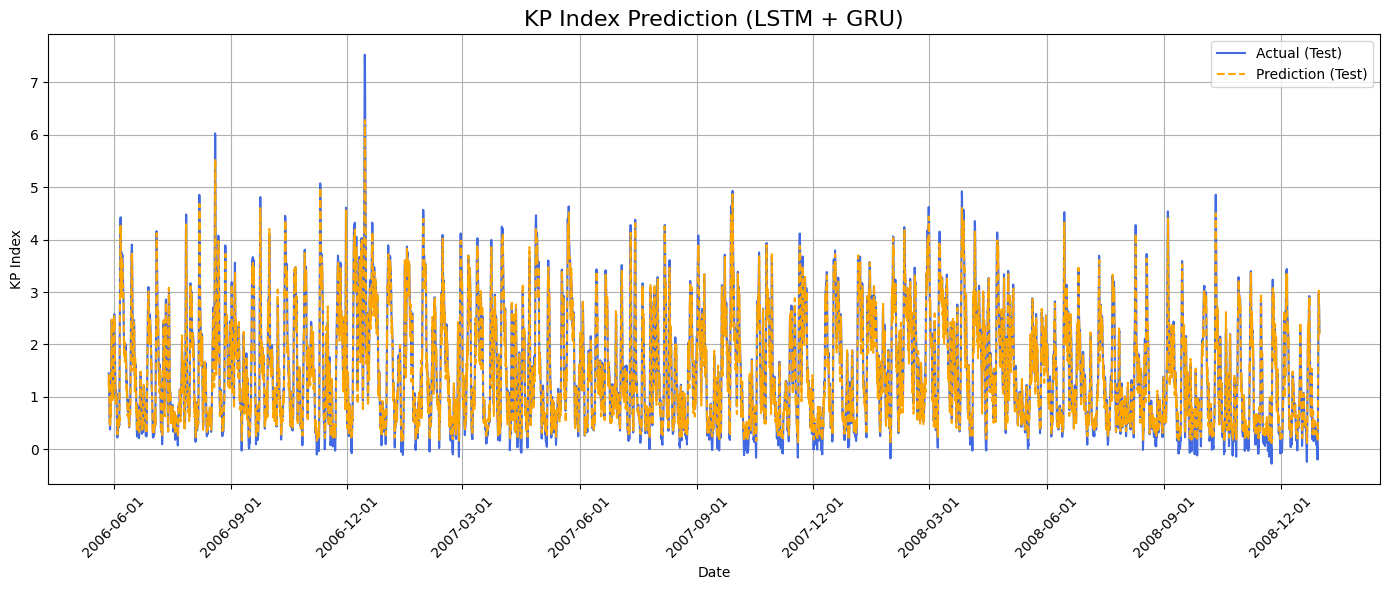

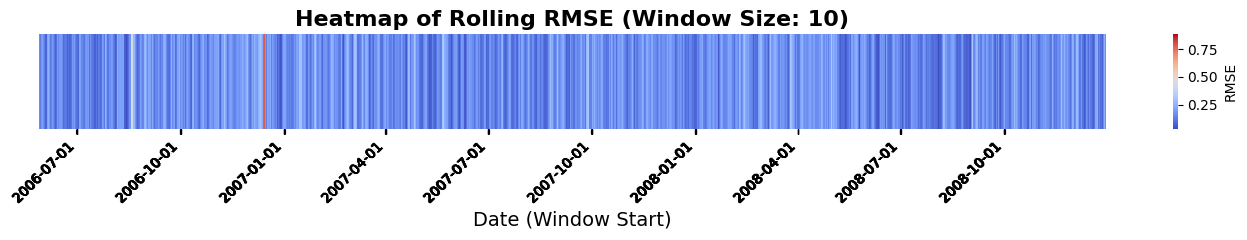

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter
from scipy.stats import ttest_1samp
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("kp index.csv")
df.columns = df.columns.str.strip()
df['value'] = savgol_filter(df['value'], 11, 3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'value']].dropna()
df.set_index('date', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['value']])

# --- Create Sequences ---
def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# --- Train/Test Split ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
test_dates = df.index[-len(y_test):]

# --- Build LSTM + GRU Hybrid Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = LSTM(128)(x)
x = Dropout(0.4)(x)
output = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predict on Test Data ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Predict on Training Data ---
y_pred_train = model.predict(X_train)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
y_train_inv = scaler.inverse_transform(y_train)

# --- Evaluation Metrics on Test Data ---
errors = y_pred_test_inv.flatten() - y_test_inv.flatten()
mbe = np.mean(errors)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
nrmse_mean = rmse / np.mean(y_test_inv)
nrmse_range = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
std_dev = np.std(errors)
t_stat, p_value = ttest_1samp(errors, 0.0)
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)

print("\n--- Evaluation Metrics on Test Data ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Normalized RMSE (mean): {nrmse_mean:.4f}")
print(f"Normalized RMSE (range): {nrmse_range:.4f}")
print(f"Standard Deviation of Errors: {std_dev:.4f}")
print(f"t-Test Statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"MAE on Test: {mae:.2f}")
print(f"R² Score on Test: {r2:.4f}")

# --- Evaluation Metrics on Training Data ---
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
train_mae = mean_absolute_error(y_train_inv, y_pred_train_inv)
train_r2 = r2_score(y_train_inv, y_pred_train_inv)

print("\n--- Evaluation Metrics on Training Data ---")
print(f"Train RMSE : {train_rmse:.3f}")
print(f"Train MAE  : {train_mae:.3f}")
print(f"Train R²   : {train_r2:.3f}")

# --- Sample Predictions ---
print("\nSample Actual vs Predicted KP Index Values:")
for i in range(10):
    print(f"Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')
plt.title("KP Index Prediction (LSTM + GRU)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("KP Index")
plt.legend()
plt.grid(True)
plt.xticks(pd.date_range(start=test_dates.min(), end=test_dates.max(), freq='3MS'), rotation=45)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE (Aligned with Dates) ---
window_size = 10
rolling_rmse = []
rolling_dates = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)
    rolling_dates.append(test_dates[i])

rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)
ax.set_xticks([i for i, date in enumerate(rolling_dates) if date.month % 3 == 1 and date.day == 1])
ax.set_xticklabels([rolling_dates[i].strftime('%Y-%m-%d') for i in range(len(rolling_dates)) if rolling_dates[i].month % 3 == 1 and rolling_dates[i].day == 1], rotation=45, ha='right')
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 313s 162ms/step - loss: 0.0403 - val_loss: 0.0019
Epoch 2/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 327s 172ms/step - loss: 0.0028 - val_loss: 7.8247e-04
Epoch 3/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 313s 165ms/step - loss: 0.0018 - val_loss: 9.0968e-04
Epoch 4/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 317s 167ms/step - loss: 0.0015 - val_loss: 5.3492e-04
Epoch 5/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 328s 173ms/step - loss: 0.0014 - val_loss: 3.9747e-04
Epoch 6/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 287s 151ms/step - loss: 0.0013 - val_loss: 3.2563e-04
Epoch 7/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 196s 103ms/step - loss: 0.0012 - val_loss: 3.8088e-04
Epoch 8/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 182s 96ms/step - loss: 0.0012 - val_loss: 6.3616e-04
Epoch 9/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 188s 99ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 193s 101ms/step - loss: 0.0011 - val_loss: 3.5574e-04
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step
949/94

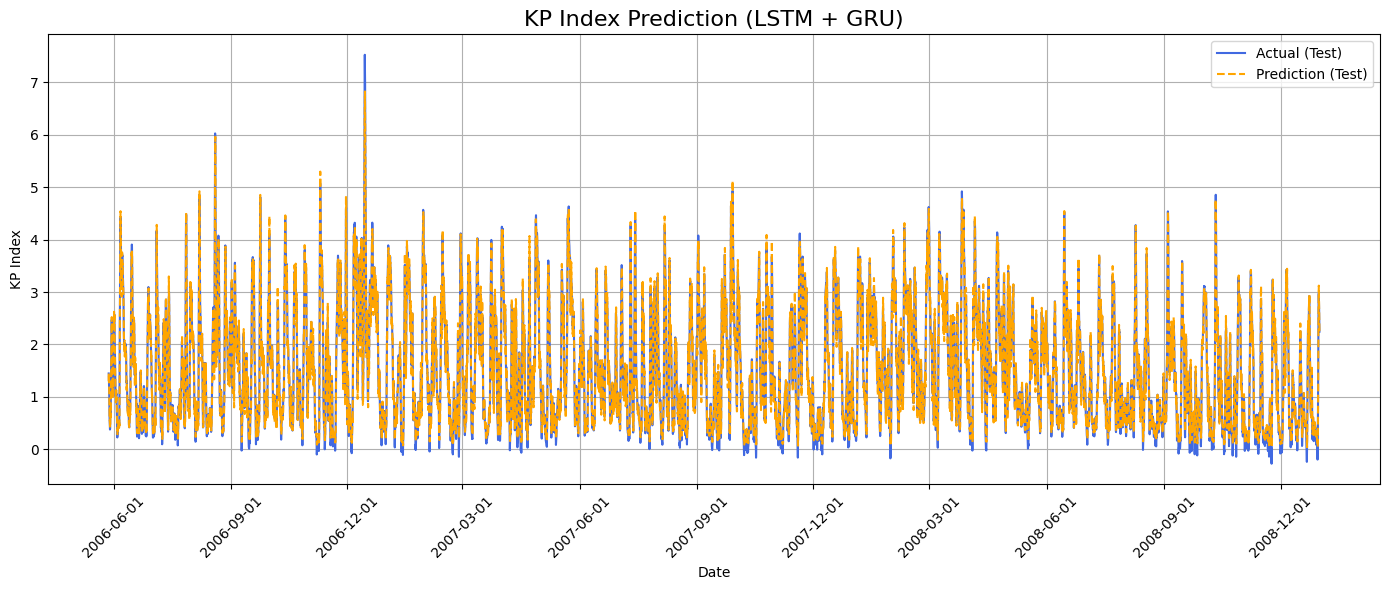

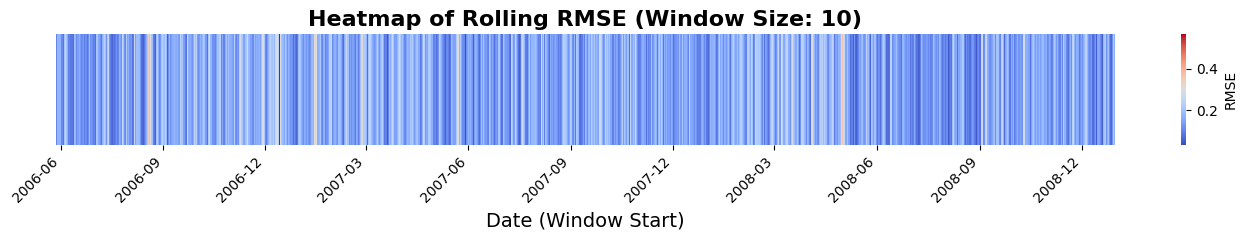

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter
from scipy.stats import ttest_1samp
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("kp index.csv")
df.columns = df.columns.str.strip()
df['value'] = savgol_filter(df['value'], 11, 3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'value']].dropna()
df.set_index('date', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['value']])

# --- Create Sequences ---
def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# --- Train/Test Split ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
test_dates = df.index[-len(y_test):]

# --- Build LSTM + GRU Hybrid Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = LSTM(128)(x)
x = Dropout(0.4)(x)
output = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predict on Test Data ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Predict on Training Data ---
y_pred_train = model.predict(X_train)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
y_train_inv = scaler.inverse_transform(y_train)

# --- Evaluation Metrics on Test Data ---
errors = y_pred_test_inv.flatten() - y_test_inv.flatten()
mbe = np.mean(errors)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
nrmse_mean = rmse / np.mean(y_test_inv)
nrmse_range = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
std_dev = np.std(errors)
t_stat, p_value = ttest_1samp(errors, 0.0)
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)

print("\n--- Evaluation Metrics on Test Data ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Normalized RMSE (mean): {nrmse_mean:.4f}")
print(f"Normalized RMSE (range): {nrmse_range:.4f}")
print(f"Standard Deviation of Errors: {std_dev:.4f}")
print(f"t-Test Statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"MAE on Test: {mae:.2f}")
print(f"R² Score on Test: {r2:.4f}")

# --- Evaluation Metrics on Training Data ---
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
train_mae = mean_absolute_error(y_train_inv, y_pred_train_inv)
train_r2 = r2_score(y_train_inv, y_pred_train_inv)

print("\n--- Evaluation Metrics on Training Data ---")
print(f"Train RMSE : {train_rmse:.3f}")
print(f"Train MAE  : {train_mae:.3f}")
print(f"Train R²   : {train_r2:.3f}")

# --- Sample Predictions ---
print("\nSample Actual vs Predicted KP Index Values:")
for i in range(10):
    print(f"Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')
plt.title("KP Index Prediction (LSTM + GRU)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("KP Index")
plt.legend()
plt.grid(True)
shared_ticks = pd.date_range(start=test_dates.min(), end=test_dates.max(), freq='3MS')
plt.xticks(shared_ticks, rotation=45)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE (Aligned with Dates) ---
window_size = 10
rolling_rmse = []
rolling_dates = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)
    rolling_dates.append(test_dates[i])

rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)
ax.set_xticks([i for i, date in enumerate(rolling_dates) if date in shared_ticks])
ax.set_xticklabels([date.strftime('%Y-%m') for date in rolling_dates if date in shared_ticks], rotation=45, ha='right')
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - loss: 0.1099 - val_loss: 0.0069
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - loss: 0.0081 - val_loss: 0.0024
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - loss: 0.0039 - val_loss: 9.0498e-04
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 130ms/step - loss: 0.0032 - val_loss: 4.9582e-04
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - loss: 0.0024 - val_loss: 4.1408e-04
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - loss: 0.0022 - val_loss: 3.9866e-04
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - loss: 0.0018 - val_loss: 3.9201e-04
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - loss: 0.0018 - val_loss: 3.4841e-04
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - loss: 0.0016 - val_loss: 4.4692e-04
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - loss: 0.0014

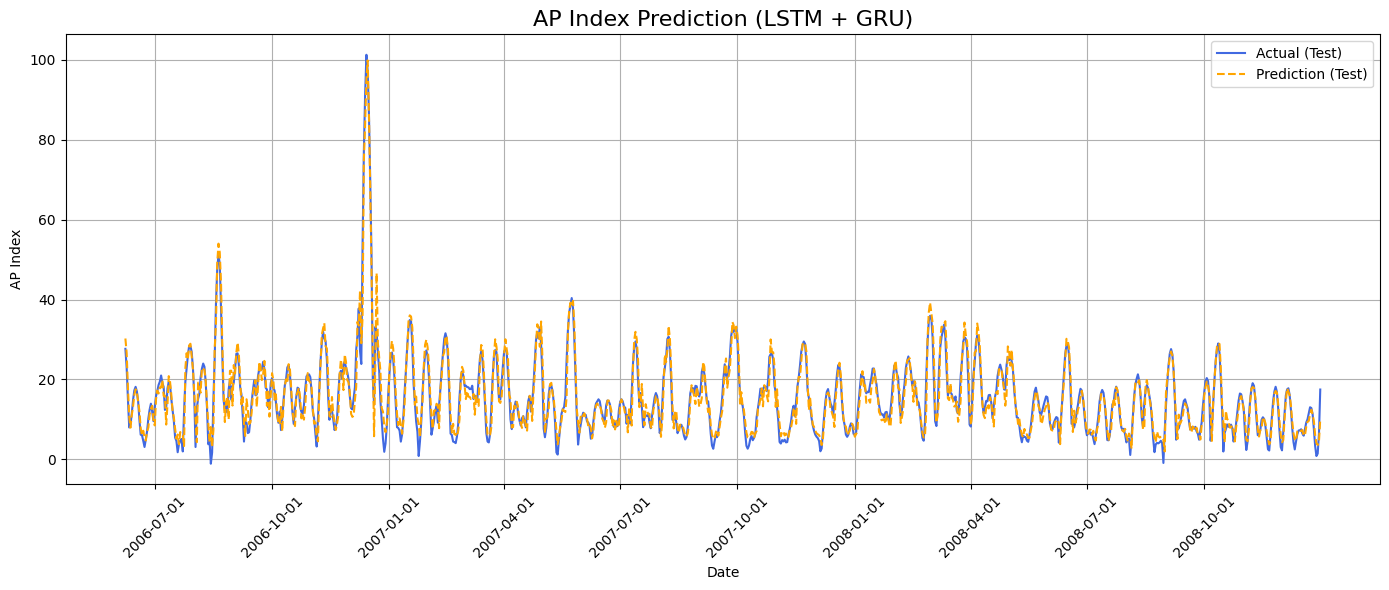

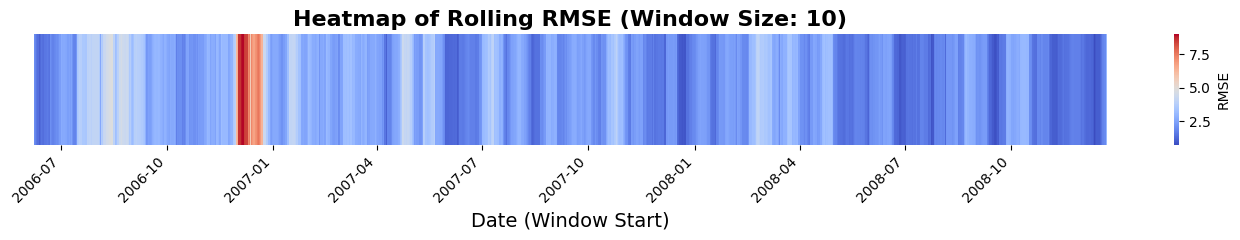

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter
from scipy.stats import ttest_1samp
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("ap_index4.csv")
df.columns = df.columns.str.strip()
df['daily_ap_index'] = savgol_filter(df['daily_ap_index'], window_length=11, polyorder=3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'daily_ap_index']].dropna()
df.set_index('date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['daily_ap_index']])

# --- Create Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Train-Test Split ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
test_dates = df.index[-len(y_test):]
train_dates = df.index[sequence_length:sequence_length+len(y_train)]

# --- Build LSTM-GRU Hybrid Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Predict on Training Data ---
y_pred_train = model.predict(X_train)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
y_train_inv = scaler.inverse_transform(y_train)

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
nrmse = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
mbe = np.mean(residuals)
t_stat = np.mean(np.abs(residuals) / std_dev)

# --- Train Metrics ---
train_residuals = y_train_inv.flatten() - y_pred_train_inv.flatten()
train_std_dev = np.std(train_residuals)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
train_mae = mean_absolute_error(y_train_inv, y_pred_train_inv)
train_r2 = r2_score(y_train_inv, y_pred_train_inv)
train_nrmse = train_rmse / (np.max(y_train_inv) - np.min(y_train_inv))
train_mbe = np.mean(train_residuals)
train_t_stat = np.mean(np.abs(train_residuals) / train_std_dev)

# --- Display Evaluation Metrics ---
print("\n--- Evaluation Metrics on Test Data ---")
print(f"RMSE           : {rmse:.3f}")
print(f"MAE            : {mae:.3f}")
print(f"MBE            : {mbe:.3f}")
print(f"NRMSE          : {nrmse:.3f}")
print(f"Standard Dev   : {std_dev:.3f}")
print(f"Test Statistic : {t_stat:.3f}")
print(f"R^2 Score      : {r2:.3f}")

print("\n--- Evaluation Metrics on Training Data ---")
print(f"Train RMSE     : {train_rmse:.3f}")
print(f"Train MAE      : {train_mae:.3f}")
print(f"Train MBE      : {train_mbe:.3f}")
print(f"Train NRMSE    : {train_nrmse:.3f}")
print(f"Train Std Dev  : {train_std_dev:.3f}")
print(f"Train T-Stat   : {train_t_stat:.3f}")
print(f"Train R^2      : {train_r2:.3f}")

# --- Sample Actual vs Predicted Values ---
print("\n--- Sample Actual vs Predicted Values ---")
for actual, pred in zip(y_test_inv[:10], y_pred_test_inv[:10]):
    print(f"Actual: {actual[0]:.3f} | Predicted: {pred[0]:.3f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')
plt.title("AP Index Prediction (LSTM + GRU)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("AP Index")
plt.legend()
plt.grid(True)
shared_ticks = pd.date_range(start=test_dates.min(), end=test_dates.max(), freq='3MS')
plt.xticks(shared_ticks, rotation=45)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE (Aligned with Dates) ---
window_size = 10
rolling_rmse = []
rolling_dates = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)
    rolling_dates.append(test_dates[i])

rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)
ax.set_xticks([i for i, date in enumerate(rolling_dates) if date in shared_ticks])
ax.set_xticklabels([date.strftime('%Y-%m') for date in rolling_dates if date in shared_ticks], rotation=45, ha='right')
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()


2025-07-04 14:00:00.147649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 267s 138ms/step - loss: 0.0403 - val_loss: 0.0017
Epoch 2/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 448s 236ms/step - loss: 0.0028 - val_loss: 7.1409e-04
Epoch 3/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 218s 115ms/step - loss: 0.0018 - val_loss: 5.7561e-04
Epoch 4/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 174s 92ms/step - loss: 0.0014 - val_loss: 4.5368e-04
Epoch 5/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 212s 112ms/step - loss: 0.0013 - val_loss: 3.5457e-04
Epoch 6/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 663s 349ms/step - loss: 0.0012 - val_loss: 5.3853e-04
Epoch 7/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 338s 178ms/step - loss: 0.0012 - val_loss: 4.3795e-04
Epoch 8/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 431s 227ms/step - loss: 0.0014 - val_loss: 7.9584e-04
Epoch 9/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 214s 113ms/step - loss: 0.0010 - val_loss: 3.9514e-04
Epoch 10/10
1898/1898 ━━━━━━━━━━━━━━━━━━━━ 197s 104ms/step - loss: 9.7815e-04 - val_loss: 3.7748e-04
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/st

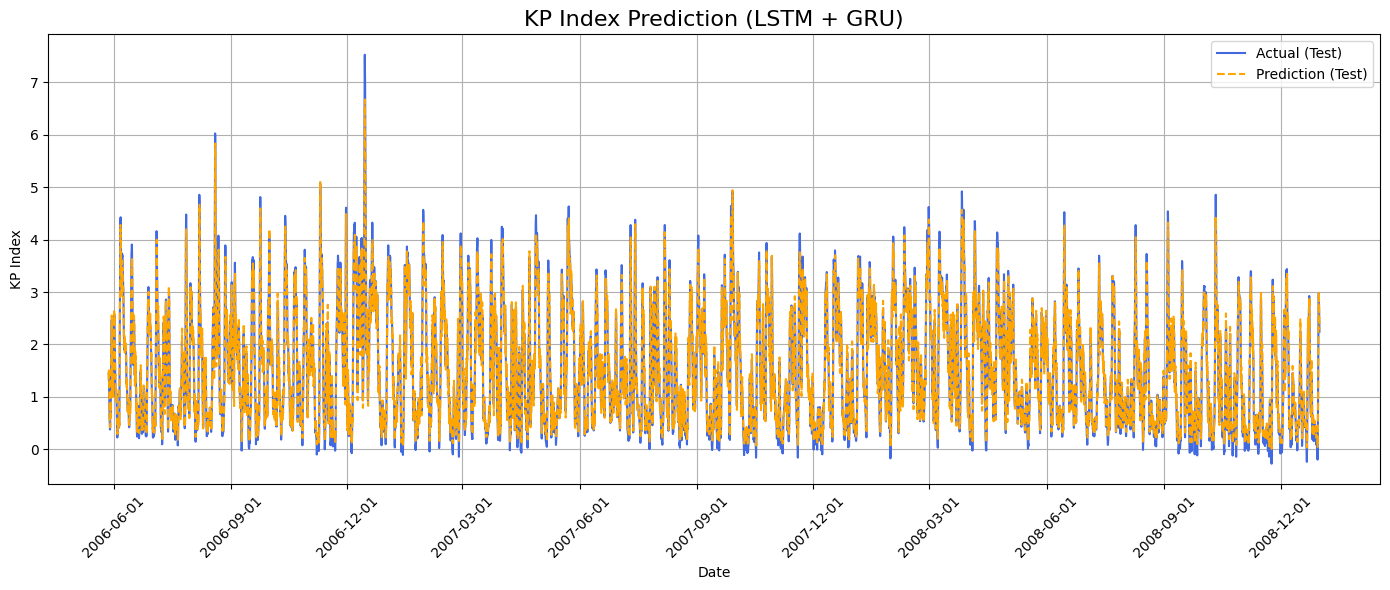

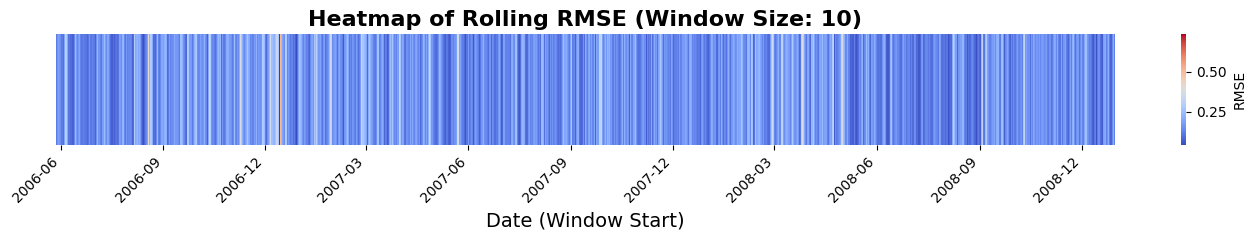

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter
from scipy.stats import ttest_1samp
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("kp index.csv")
df.columns = df.columns.str.strip()
df['value'] = savgol_filter(df['value'], 11, 3)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'value']].dropna()
df.set_index('date', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['value']])

# --- Create Sequences ---
def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# --- Train/Test Split ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
test_dates = df.index[-len(y_test):]
train_dates = df.index[sequence_length:sequence_length + len(y_train)]

# --- Build LSTM + GRU Hybrid Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = LSTM(128)(x)
x = Dropout(0.4)(x)
output = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predict on Test Data ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Predict on Training Data ---
y_pred_train = model.predict(X_train)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
y_train_inv = scaler.inverse_transform(y_train)

# --- Evaluation Metrics on Test Data ---
errors_test = y_pred_test_inv.flatten() - y_test_inv.flatten()
mbe = np.mean(errors_test)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
nrmse_mean = rmse / np.mean(y_test_inv)
nrmse_range = rmse / (np.max(y_test_inv) - np.min(y_test_inv))
std_dev = np.std(errors_test)
t_stat, p_value = ttest_1samp(errors_test, 0.0)
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)

print("\n--- Evaluation Metrics on Test Data ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Normalized RMSE (mean): {nrmse_mean:.4f}")
print(f"Normalized RMSE (range): {nrmse_range:.4f}")
print(f"Standard Deviation of Errors: {std_dev:.4f}")
print(f"t-Test Statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"MAE on Test: {mae:.2f}")
print(f"R² Score on Test: {r2:.4f}")

# --- Evaluation Metrics on Training Data ---
errors_train = y_pred_train_inv.flatten() - y_train_inv.flatten()
train_mbe = np.mean(errors_train)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
train_nrmse_mean = train_rmse / np.mean(y_train_inv)
train_nrmse_range = train_rmse / (np.max(y_train_inv) - np.min(y_train_inv))
train_std_dev = np.std(errors_train)
train_t_stat, train_p_value = ttest_1samp(errors_train, 0.0)
train_mae = mean_absolute_error(y_train_inv, y_pred_train_inv)
train_r2 = r2_score(y_train_inv, y_pred_train_inv)

print("\n--- Evaluation Metrics on Training Data ---")
print(f"Train MBE : {train_mbe:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Train NRMSE (mean): {train_nrmse_mean:.4f}")
print(f"Train NRMSE (range): {train_nrmse_range:.4f}")
print(f"Train Std Dev: {train_std_dev:.4f}")
print(f"Train T-Statistic: {train_t_stat:.4f}")
print(f"Train p-value: {train_p_value:.4f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train R² Score: {train_r2:.4f}")

# --- Sample Predictions ---
print("\nSample Actual vs Predicted KP Index Values:")
for i in range(10):
    print(f"Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label='Actual (Test)', color='royalblue')
plt.plot(test_dates, y_pred_test_inv, label='Prediction (Test)', color='orange', linestyle='--')
plt.title("KP Index Prediction (LSTM + GRU)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("KP Index")
plt.legend()
plt.grid(True)
shared_ticks = pd.date_range(start=test_dates.min(), end=test_dates.max(), freq='3MS')
plt.xticks(shared_ticks, rotation=45)
plt.tight_layout()
plt.show()

# --- Heatmap of Rolling RMSE (Aligned with Dates) ---
window_size = 10
rolling_rmse = []
rolling_dates = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)
    rolling_dates.append(test_dates[i])

rolling_rmse_reshaped = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)
ax.set_xticks([i for i, date in enumerate(rolling_dates) if date in shared_ticks])
ax.set_xticklabels([date.strftime('%Y-%m') for date in rolling_dates if date in shared_ticks], rotation=45, ha='right')
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_21          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_22          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - loss: 0.6455 - val_loss: 0.0223
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - loss: 0.0513 - val_loss: 0.0096
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - loss: 0.0309 - val_loss: 0.0050
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - loss: 0.0196 - val_loss: 0.0028
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - loss: 0.0154 - val_loss: 0.0024
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - loss: 0.0124 - val_loss: 0.0022
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 657ms/step - loss: 0.0104 - val_loss: 0.0021
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 739ms/step - loss: 0.0090 - val_loss: 0.0028
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 750ms/step - loss: 0.0078 - val_loss: 0.0021
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 527ms/step - loss: 0.0072 - val_loss: 0.0021
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 523ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━

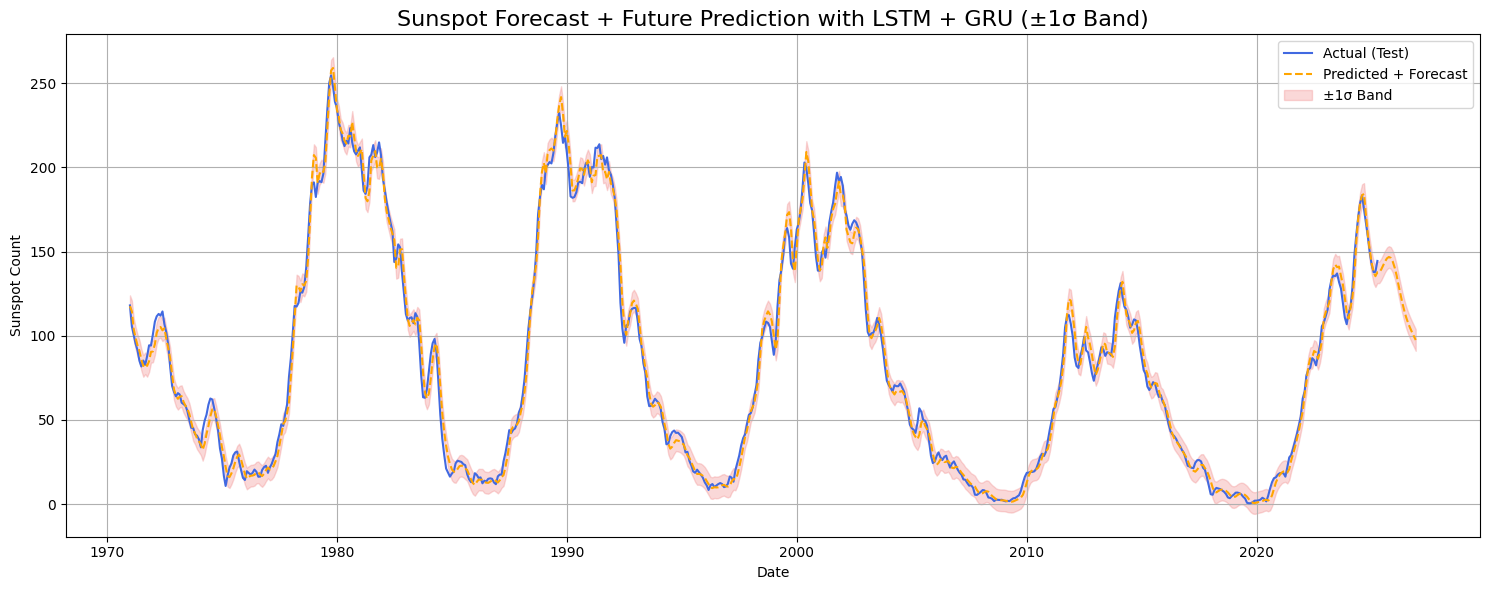


--- Future Sunspot Predictions ---
2025-05-01 : 137.69 ± 6.43 (Range: 131.26 to 144.11)
2025-06-01 : 139.36 ± 6.43 (Range: 132.93 to 145.78)
2025-07-01 : 141.70 ± 6.43 (Range: 135.27 to 148.12)
2025-08-01 : 144.13 ± 6.43 (Range: 137.70 to 150.55)
2025-09-01 : 146.00 ± 6.43 (Range: 139.57 to 152.42)
2025-10-01 : 146.80 ± 6.43 (Range: 140.38 to 153.23)
2025-11-01 : 146.19 ± 6.43 (Range: 139.77 to 152.62)
2025-12-01 : 144.05 ± 6.43 (Range: 137.62 to 150.48)
2026-01-01 : 140.47 ± 6.43 (Range: 134.05 to 146.90)
2026-02-01 : 135.79 ± 6.43 (Range: 129.36 to 142.22)
2026-03-01 : 130.46 ± 6.43 (Range: 124.04 to 136.89)
2026-04-01 : 124.99 ± 6.43 (Range: 118.56 to 131.41)
2026-05-01 : 119.78 ± 6.43 (Range: 113.35 to 126.21)
2026-06-01 : 115.10 ± 6.43 (Range: 108.67 to 121.52)
2026-07-01 : 111.07 ± 6.43 (Range: 104.64 to 117.50)
2026-08-01 : 107.69 ± 6.43 (Range: 101.26 to 114.12)
2026-09-01 : 104.81 ± 6.43 (Range: 98.39 to 111.24)
2026-10-01 : 102.27 ± 6.43 (Range: 95.85 to 108.70)
2026-11-01 :

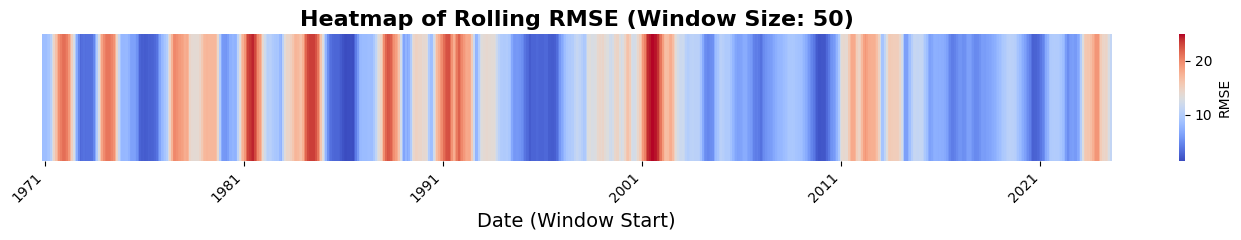


--- Additional Evaluation Metrics ---
Mean Bias Error (MBE): -0.0211
Normalized RMSE (NRMSE): 0.0253
Test Statistic         : 0.0093

--- Sample Actual vs Predicted Sunspot Values ---
 1. Actual: 118.01 | Predicted: 117.58
 2. Actual: 105.46 | Predicted: 114.45
 3. Actual: 100.51 | Predicted: 104.20
 4. Actual: 95.23 | Predicted: 98.66
 5. Actual: 91.43 | Predicted: 94.31
 6. Actual: 85.07 | Predicted: 90.95
 7. Actual: 81.72 | Predicted: 85.78
 8. Actual: 85.25 | Predicted: 82.05
 9. Actual: 82.74 | Predicted: 83.62
10. Actual: 87.88 | Predicted: 82.10


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions on Test Set ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 20
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Create Future Dates ---
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Combine Test and Forecast Dates ---
total_dates = np.concatenate([df.index[-len(y_test):], future_dates])
total_values = np.concatenate([y_pred_test_inv.flatten(), future_preds_inv.flatten()])
total_upper = total_values + std_dev
total_lower = total_values - std_dev

# --- Plot Actual vs Predicted + Future Forecasts with ±1σ ---
plt.figure(figsize=(15, 6))
plt.plot(df.index[-len(y_test):], y_test_inv.flatten(), label='Actual (Test)', color='royalblue')
plt.plot(total_dates, total_values, label='Predicted + Forecast', color='orange', linestyle='--')
plt.fill_between(total_dates, total_lower, total_upper, color='lightcoral', alpha=0.3, label='±1σ Band')
plt.title("Sunspot Forecast + Future Prediction with LSTM + GRU (±1σ Band)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Future Predictions ---
print("\n--- Future Sunspot Predictions ---")
for date, value in zip(future_dates, future_preds_inv):
    lower = value[0] - std_dev
    upper = value[0] + std_dev
    print(f"{date.date()} : {value[0]:.2f} ± {std_dev:.2f} (Range: {lower:.2f} to {upper:.2f})")

# --- Print Evaluation Metrics ---
print("\n--- Core Evaluation Metrics ---")
print(f"RMSE              : {rmse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Std. Dev. of Error: {std_dev:.2f}")
print(f"Pearson r         : {pearson_r:.3f}")

# --- Rolling RMSE Plot ---
window_size = 50
rolling_rmse = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)

rolling_rmse = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)
ax.set_xticks([i for i, date in enumerate(rolling_dates) if date in shared_ticks])
ax.set_xticklabels([date.strftime('%Y') for date in rolling_dates if date in shared_ticks], rotation=45, ha='right')
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()

# --- Additional Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

mbe = mean_bias_error(y_test_inv, y_pred_test_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_test_inv)
test_statistic = np.mean((y_pred_test_inv - y_test_inv) ** 2) / np.var(y_test_inv)

print("\n--- Additional Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic         : {test_statistic:.4f}")

# --- Display Sample Predictions ---
print("\n--- Sample Actual vs Predicted Sunspot Values ---")
for i in range(10):
    print(f"{i+1:>2}. Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_25          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_26          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.1229 - val_loss: 0.0031
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0100 - val_loss: 0.0023
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 12/100
163/

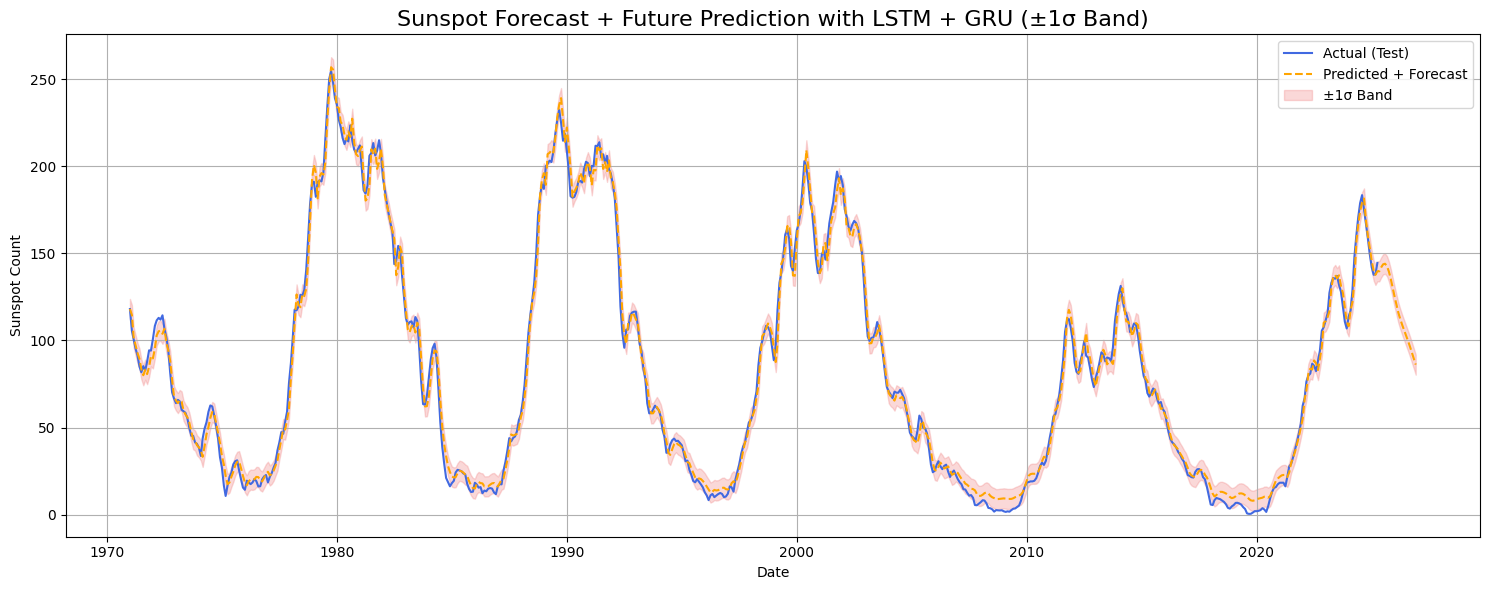


--- Future Sunspot Predictions ---
2025-05-01 : 139.68 ± 5.77 (Range: 133.91 to 145.46)
2025-06-01 : 141.96 ± 5.77 (Range: 136.19 to 147.73)
2025-07-01 : 143.68 ± 5.77 (Range: 137.90 to 149.45)
2025-08-01 : 144.02 ± 5.77 (Range: 138.25 to 149.79)
2025-09-01 : 142.61 ± 5.77 (Range: 136.83 to 148.38)
2025-10-01 : 139.50 ± 5.77 (Range: 133.73 to 145.28)
2025-11-01 : 135.13 ± 5.77 (Range: 129.35 to 140.90)
2025-12-01 : 130.06 ± 5.77 (Range: 124.29 to 135.84)
2026-01-01 : 124.90 ± 5.77 (Range: 119.12 to 130.67)
2026-02-01 : 120.07 ± 5.77 (Range: 114.30 to 125.85)
2026-03-01 : 115.81 ± 5.77 (Range: 110.03 to 121.58)
2026-04-01 : 112.11 ± 5.77 (Range: 106.34 to 117.89)
2026-05-01 : 108.85 ± 5.77 (Range: 103.08 to 114.63)
2026-06-01 : 105.80 ± 5.77 (Range: 100.03 to 111.57)
2026-07-01 : 102.79 ± 5.77 (Range: 97.01 to 108.56)
2026-08-01 : 99.70 ± 5.77 (Range: 93.93 to 105.48)
2026-09-01 : 96.47 ± 5.77 (Range: 90.69 to 102.24)
2026-10-01 : 93.08 ± 5.77 (Range: 87.31 to 98.86)
2026-11-01 : 89.61

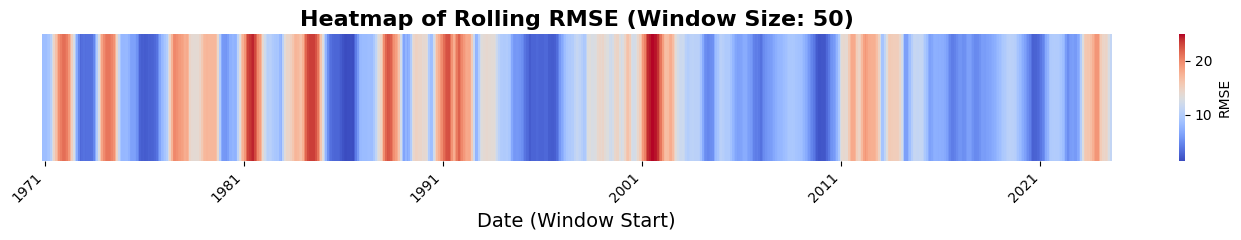


--- Additional Evaluation Metrics ---
Mean Bias Error (MBE): 0.6825
Normalized RMSE (NRMSE): 0.0229
Test Statistic         : 0.0076

--- Sample Actual vs Predicted Sunspot Values ---
 1. Actual: 118.01 | Predicted: 118.06
 2. Actual: 105.46 | Predicted: 114.57
 3. Actual: 100.51 | Predicted: 101.72
 4. Actual: 95.23 | Predicted: 97.22
 5. Actual: 91.43 | Predicted: 92.86
 6. Actual: 85.07 | Predicted: 89.54
 7. Actual: 81.72 | Predicted: 83.50
 8. Actual: 85.25 | Predicted: 80.03
 9. Actual: 82.74 | Predicted: 83.23
10. Actual: 87.88 | Predicted: 80.67


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions on Test Set ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 20
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Create Future Dates ---
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())

# --- Combine Test and Forecast Dates ---
total_dates = np.concatenate([df.index[-len(y_test):], future_dates])
total_values = np.concatenate([y_pred_test_inv.flatten(), future_preds_inv.flatten()])
total_upper = total_values + std_dev
total_lower = total_values - std_dev

# --- Plot Actual vs Predicted + Future Forecasts with ±1σ ---
plt.figure(figsize=(15, 6))
plt.plot(df.index[-len(y_test):], y_test_inv.flatten(), label='Actual (Test)', color='royalblue')
plt.plot(total_dates, total_values, label='Predicted + Forecast', color='orange', linestyle='--')
plt.fill_between(total_dates, total_lower, total_upper, color='lightcoral', alpha=0.3, label='±1σ Band')
plt.title("Sunspot Forecast + Future Prediction with LSTM + GRU (±1σ Band)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Future Predictions ---
print("\n--- Future Sunspot Predictions ---")
for date, value in zip(future_dates, future_preds_inv):
    lower = value[0] - std_dev
    upper = value[0] + std_dev
    print(f"{date.date()} : {value[0]:.2f} ± {std_dev:.2f} (Range: {lower:.2f} to {upper:.2f})")

# --- Print Evaluation Metrics ---
print("\n--- Core Evaluation Metrics ---")
print(f"RMSE              : {rmse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Std. Dev. of Error: {std_dev:.2f}")
print(f"Pearson r         : {pearson_r:.3f}")

# --- Rolling RMSE Plot ---
window_size = 50
rolling_rmse = []

for i in range(0, len(y_test_inv) - window_size + 1):
    y_true_window = y_test_inv[i:i + window_size]
    y_pred_window = y_pred_test_inv[i:i + window_size]
    rmse_window = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse_window)

rolling_rmse = np.array(rolling_rmse).reshape(1, -1)

plt.figure(figsize=(14, 2.5))
ax = sns.heatmap(rolling_rmse_reshaped, cmap='coolwarm', cbar_kws={'label': 'RMSE'}, xticklabels=rolling_dates)
ax.set_xticks([i for i, date in enumerate(rolling_dates) if date in shared_ticks])
ax.set_xticklabels([date.strftime('%Y') for date in rolling_dates if date in shared_ticks], rotation=45, ha='right')
plt.title(f'Heatmap of Rolling RMSE (Window Size: {window_size})', fontsize=16, fontweight='bold')
plt.yticks([])
plt.xlabel('Date (Window Start)', fontsize=14)
plt.tight_layout()
plt.show()


# --- Additional Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

mbe = mean_bias_error(y_test_inv, y_pred_test_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_test_inv)
test_statistic = np.mean((y_pred_test_inv - y_test_inv) ** 2) / np.var(y_test_inv)

print("\n--- Additional Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic         : {test_statistic:.4f}")

# --- Display Sample Predictions ---
print("\n--- Sample Actual vs Predicted Sunspot Values ---")
for i in range(10):
    print(f"{i+1:>2}. Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_27          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_28          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - loss: 0.1384 - val_loss: 0.0026
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 0.0084 - val_loss: 0.0021
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 297ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 12

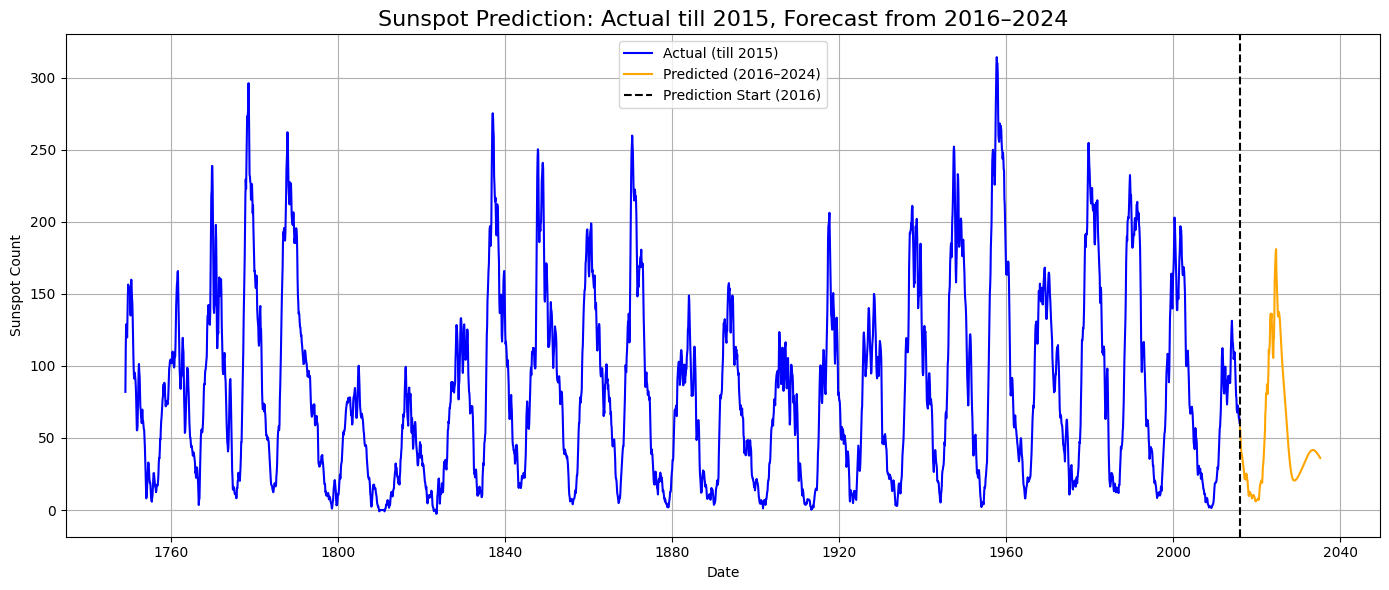


--- Future Sunspot Predictions ---
2025-05-01 : 137.43 ± 5.37 (Range: 132.07 to 142.80)
2025-06-01 : 136.32 ± 5.37 (Range: 130.95 to 141.68)
2025-07-01 : 134.32 ± 5.37 (Range: 128.96 to 139.69)
2025-08-01 : 131.32 ± 5.37 (Range: 125.95 to 136.69)
2025-09-01 : 127.36 ± 5.37 (Range: 122.00 to 132.73)
2025-10-01 : 122.73 ± 5.37 (Range: 117.36 to 128.09)
2025-11-01 : 117.79 ± 5.37 (Range: 112.43 to 123.16)
2025-12-01 : 112.94 ± 5.37 (Range: 107.57 to 118.31)
2026-01-01 : 108.45 ± 5.37 (Range: 103.08 to 113.81)
2026-02-01 : 104.43 ± 5.37 (Range: 99.06 to 109.79)
2026-03-01 : 100.86 ± 5.37 (Range: 95.50 to 106.23)
2026-04-01 : 97.64 ± 5.37 (Range: 92.27 to 103.00)
2026-05-01 : 94.59 ± 5.37 (Range: 89.22 to 99.96)
2026-06-01 : 91.56 ± 5.37 (Range: 86.19 to 96.93)
2026-07-01 : 88.47 ± 5.37 (Range: 83.10 to 93.84)
2026-08-01 : 85.30 ± 5.37 (Range: 79.94 to 90.67)
2026-09-01 : 82.05 ± 5.37 (Range: 76.68 to 87.42)
2026-10-01 : 78.73 ± 5.37 (Range: 73.37 to 84.10)
2026-11-01 : 75.37 ± 5.37 (Range

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions on Test Set ---
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 10 * 12  # Forecast for 20 years monthly
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# --- Create Future Dates ---
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# --- Evaluation Metrics ---
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()
std_dev = np.std(residuals)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_test_inv.flatten())



# --- Combined Plot: Actual till 2015, Predicted from 2016–2024 ---
actual_upto_2015 = df[df.index < '2016-01-01']['sunspot']
test_pred_dates = df.index[-len(y_test_inv):]
start_2016_index = np.where(test_pred_dates >= pd.to_datetime('2016-01-01'))[0][0]
predicted_2016_2024 = np.concatenate([y_pred_test_inv[start_2016_index:], future_preds_inv])
predicted_2016_2024_dates = pd.date_range(start=test_pred_dates[start_2016_index], periods=len(predicted_2016_2024), freq='MS')

plt.figure(figsize=(14, 6))
plt.plot(actual_upto_2015.index, actual_upto_2015.values, label='Actual (till 2015)', color='blue')
plt.plot(predicted_2016_2024_dates, predicted_2016_2024, label='Predicted (2016–2024)', color='orange')
plt.axvline(pd.to_datetime('2016-01-01'), color='black', linestyle='--', label='Prediction Start (2016)')
plt.title("Sunspot Prediction: Actual till 2015, Forecast from 2016–2024", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation Reports ---
print("\n--- Future Sunspot Predictions ---")
for date, value in zip(future_dates, future_preds_inv):
    lower = value[0] - std_dev
    upper = value[0] + std_dev
    print(f"{date.date()} : {value[0]:.2f} ± {std_dev:.2f} (Range: {lower:.2f} to {upper:.2f})")

print("\n--- Core Evaluation Metrics ---")
print(f"RMSE              : {rmse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Std. Dev. of Error: {std_dev:.2f}")
print(f"Pearson r         : {pearson_r:.3f}")



# --- Additional Evaluation Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

mbe = mean_bias_error(y_test_inv, y_pred_test_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_test_inv)
test_statistic = np.mean((y_pred_test_inv - y_test_inv) ** 2) / np.var(y_test_inv)

print("\n--- Additional Evaluation Metrics ---")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic         : {test_statistic:.4f}")

print("\n--- Sample Actual vs Predicted Sunspot Values ---")
for i in range(10):
    print(f"{i+1:>2}. Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_test_inv[i][0]:.2f}")


Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - loss: 0.1677 - val_loss: 0.0014
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 35s 179ms/step - loss: 0.0026 - val_loss: 8.5121e-04
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 0.0026 - val_loss: 7.0711e-04
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - loss: 0.0022 - val_loss: 6.6144e-04
Epoch 9/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - loss: 0.0022 - val_loss: 4.2856e-04
Epoch 10/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step - loss: 0.0017 - val_loss: 4.3700e-04
Epoch 11/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 173ms/step - loss: 0.0017 - val_l

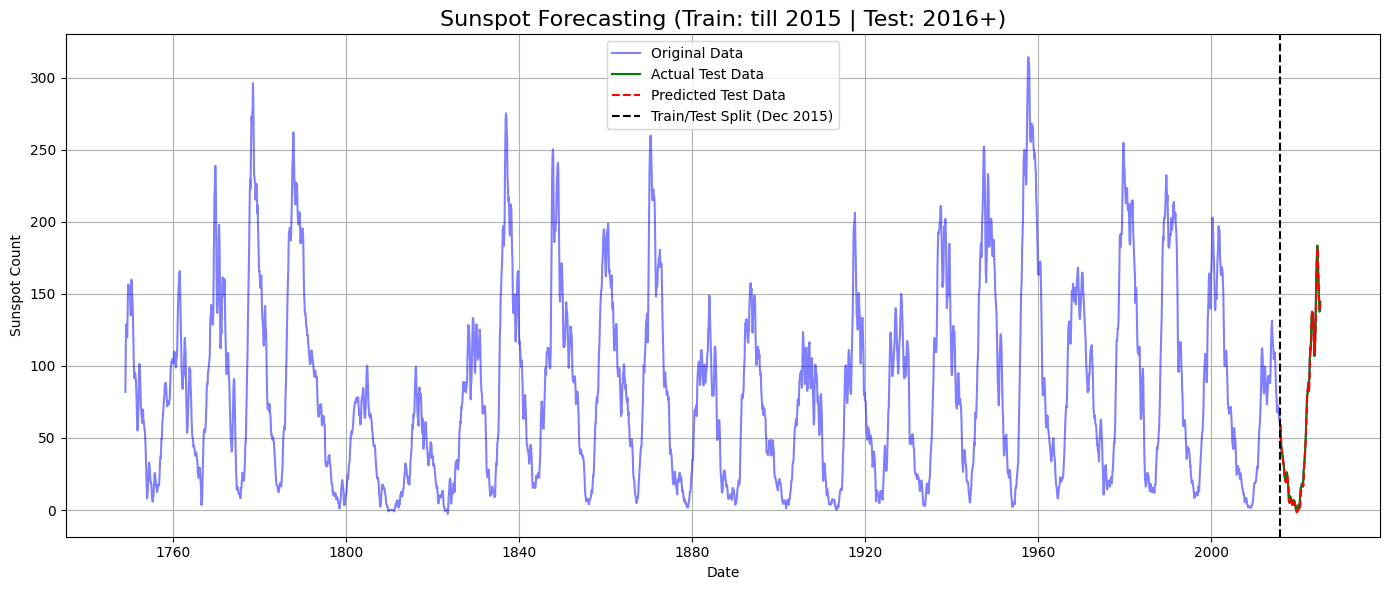


--- Evaluation on Test Data (Post-2015) ---
RMSE              : 3.36
MAE               : 2.61
R² Score          : 0.9963
Pearson r         : 0.998
Standard Deviation of Errors: 3.28
Mean Bias Error (MBE): -0.7551
Normalized RMSE (NRMSE): 0.0184
Test Statistic         : 0.0037

--- Sample Predictions ---
2016-01-01 | Actual: 58.95 | Predicted: 59.43
2016-02-01 | Actual: 52.99 | Predicted: 57.45
2016-03-01 | Actual: 47.63 | Predicted: 51.13
2016-04-01 | Actual: 43.39 | Predicted: 45.18
2016-05-01 | Actual: 41.43 | Predicted: 40.82
2016-06-01 | Actual: 40.28 | Predicted: 39.10
2016-07-01 | Actual: 38.63 | Predicted: 38.31
2016-08-01 | Actual: 36.09 | Predicted: 36.69
2016-09-01 | Actual: 34.51 | Predicted: 33.85
2016-10-01 | Actual: 32.08 | Predicted: 31.90


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and preprocess data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize sunspot data ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['sunspot']])

# --- Create sequences ---
def create_sequences(data, dates, seq_len=60):
    X, y, date_idx = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
        date_idx.append(dates[i + seq_len])
    return np.array(X), np.array(y), np.array(date_idx)

X, y, date_idx = create_sequences(scaled_data, df.index, seq_len=60)

# --- Train/Test Split by date ---
train_cutoff = pd.to_datetime("2015-12-01")
train_idx = np.where(date_idx <= train_cutoff)[0]
test_idx = np.where(date_idx > train_cutoff)[0]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
test_dates = date_idx[test_idx]

# --- Build model ---
input_layer = Input(shape=(60, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')

# --- Train the model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predict on test set ---
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# --- Evaluation Metrics ---
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def normalized_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
pearson_r, _ = pearsonr(y_test_inv.flatten(), y_pred_inv.flatten())
std_dev = np.std(y_test_inv.flatten() - y_pred_inv.flatten())
mbe = mean_bias_error(y_test_inv, y_pred_inv)
nrmse = normalized_rmse(y_test_inv, y_pred_inv)
test_stat = np.mean((y_pred_inv - y_test_inv)**2) / np.var(y_test_inv)

# --- Plotting ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['sunspot'], label='Original Data', color='blue', alpha=0.5)
plt.plot(test_dates, y_test_inv, label='Actual Test Data', color='green')
plt.plot(test_dates, y_pred_inv, label='Predicted Test Data',linestyle='--', color='red')
plt.axvline(train_cutoff, color='black', linestyle='--', label='Train/Test Split (Dec 2015)')
plt.title('Sunspot Forecasting (Train: till 2015 | Test: 2016+)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sunspot Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Evaluation Metrics ---
print("\n--- Evaluation on Test Data (Post-2015) ---")
print(f"RMSE              : {rmse:.2f}")
print(f"MAE               : {mae:.2f}")
print(f"R² Score          : {r2:.4f}")
print(f"Pearson r         : {pearson_r:.3f}")
print(f"Standard Deviation of Errors: {std_dev:.2f}")
print(f"Mean Bias Error (MBE): {mbe:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"Test Statistic         : {test_stat:.4f}")

print("\n--- Sample Predictions ---")
for i in range(10):
    print(f"{test_dates[i].date()} | Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_inv[i][0]:.2f}")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,857 (1.14 MB)

 Trainable params: 297,857 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - loss: 0.2200 - val_loss: 0.0035
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0083 - val_loss: 0.0019
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.0023 - val_loss: 9.3179e-04
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - loss: 0.0024 - val_loss: 7.6570e-04
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - loss: 0.0023 - val_loss: 6.1816e-04
Epo

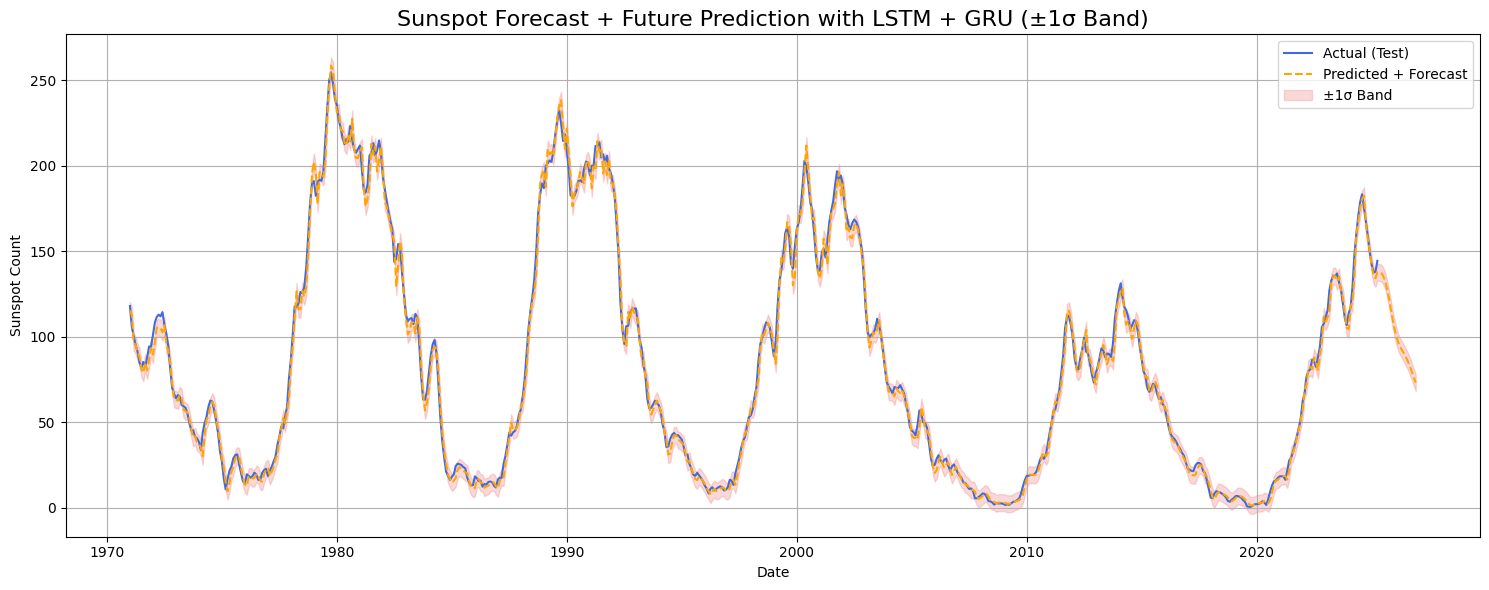


--- Training Data Evaluation Metrics ---
RMSE              : 5.56
MAE               : 4.06
R² Score          : 0.9927
Std. Dev. of Error: 5.44
Pearson r         : 0.997
MBE               : -1.1405
Normalized RMSE   : 0.0175
Test Statistic    : 0.0073

--- Test Data Evaluation Metrics ---
RMSE              : 5.07
MAE               : 3.73
R² Score          : 0.9942
Std. Dev. of Error: 4.94
Pearson r         : 0.997
MBE               : -1.1428
Normalized RMSE   : 0.0200
Test Statistic    : 0.0058

--- Future Sunspot Predictions ---
2025-05-01 : 137.76 ± 4.94 (Range: 132.81 to 142.70)
2025-06-01 : 137.26 ± 4.94 (Range: 132.31 to 142.20)
2025-07-01 : 135.76 ± 4.94 (Range: 130.81 to 140.70)
2025-08-01 : 132.83 ± 4.94 (Range: 127.88 to 137.77)
2025-09-01 : 128.37 ± 4.94 (Range: 123.42 to 133.31)
2025-10-01 : 122.65 ± 4.94 (Range: 117.71 to 127.60)
2025-11-01 : 116.27 ± 4.94 (Range: 111.33 to 121.22)
2025-12-01 : 109.95 ± 4.94 (Range: 105.01 to 114.90)
2026-01-01 : 104.34 ± 4.94 (Range: 99.40

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# --- Load and Preprocess Data ---
df = pd.read_csv("SN_m_tot_V3.csv", sep=';')
df.columns = df.columns.str.strip()
df = df[['year', 'month', 'sunspot']].dropna()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['sunspot'] = savgol_filter(df['sunspot'], window_length=11, polyorder=3)
df.set_index('date', inplace=True)

# --- Normalize Sunspot Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['sunspot']])

# --- Create Input Sequences ---
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# --- Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- Build the LSTM + GRU Model ---
input_layer = Input(shape=(sequence_length, 1))
x = LSTM(128, return_sequences=True)(input_layer)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# --- Predictions ---
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# --- Inverse Transform ---
y_test_inv = scaler.inverse_transform(y_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_train_inv = scaler.inverse_transform(y_train)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)

# --- Evaluation Function ---
def evaluate_metrics(y_true, y_pred):
    residuals = y_true.flatten() - y_pred.flatten()
    std_dev = np.std(residuals)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pearson_r, _ = pearsonr(y_true.flatten(), y_pred.flatten())
    mbe = np.mean(y_pred - y_true)
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    test_stat = np.mean((y_pred - y_true)**2) / np.var(y_true)
    return rmse, mae, r2, std_dev, pearson_r, mbe, nrmse, test_stat

# --- Training Metrics ---
rmse_train, mae_train, r2_train, std_train, r_train, mbe_train, nrmse_train, ts_train = evaluate_metrics(y_train_inv, y_pred_train_inv)

# --- Test Metrics ---
rmse_test, mae_test, r2_test, std_test, r_test, mbe_test, nrmse_test, ts_test = evaluate_metrics(y_test_inv, y_pred_test_inv)

# --- Forecast Future Sunspot Values ---
last_seq = X[-1].reshape(1, sequence_length, 1)
future_steps = 20
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_seq)[0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# --- Plotting Actual vs Predicted and Forecast ---
total_dates = np.concatenate([df.index[-len(y_test):], future_dates])
total_values = np.concatenate([y_pred_test_inv.flatten(), future_preds_inv.flatten()])
total_upper = total_values + std_test
total_lower = total_values - std_test

plt.figure(figsize=(15, 6))
plt.plot(df.index[-len(y_test):], y_test_inv.flatten(), label='Actual (Test)', color='royalblue')
plt.plot(total_dates, total_values, label='Predicted + Forecast', color='orange', linestyle='--')
plt.fill_between(total_dates, total_lower, total_upper, color='lightcoral', alpha=0.3, label='±1σ Band')
plt.title("Sunspot Forecast + Future Prediction with LSTM + GRU (±1σ Band)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Evaluation Results ---
print("\n--- Training Data Evaluation Metrics ---")
print(f"RMSE              : {rmse_train:.2f}")
print(f"MAE               : {mae_train:.2f}")
print(f"R² Score          : {r2_train:.4f}")
print(f"Std. Dev. of Error: {std_train:.2f}")
print(f"Pearson r         : {r_train:.3f}")
print(f"MBE               : {mbe_train:.4f}")
print(f"Normalized RMSE   : {nrmse_train:.4f}")
print(f"Test Statistic    : {ts_train:.4f}")

print("\n--- Test Data Evaluation Metrics ---")
print(f"RMSE              : {rmse_test:.2f}")
print(f"MAE               : {mae_test:.2f}")
print(f"R² Score          : {r2_test:.4f}")
print(f"Std. Dev. of Error: {std_test:.2f}")
print(f"Pearson r         : {r_test:.3f}")
print(f"MBE               : {mbe_test:.4f}")
print(f"Normalized RMSE   : {nrmse_test:.4f}")
print(f"Test Statistic    : {ts_test:.4f}")

# --- Print Future Forecasts ---
print("\n--- Future Sunspot Predictions ---")
for date, value in zip(future_dates, future_preds_inv):
    lower = value[0] - std_test
    upper = value[0] + std_test
    print(f"{date.date()} : {value[0]:.2f} ± {std_test:.2f} (Range: {lower:.2f} to {upper:.2f})")